In [1]:
import numpy as np
import os
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from toolbox.utils import set_random_seed
import subprocess

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [ ]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

: 

: 

In [3]:
# set random seed for reproducibility
set_random_seed(seed=42)

2025-12-05 17:08:35.872334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-12-05 17:08:35.872371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


Seed set to 42


# Scaling control

see anshul_1on1_10312025.m4a, around 26'  
also: https://chatgpt.com/c/69307ade-8af0-832a-b470-c4a39e970309.  
also see my drawing: chip_vs_control.png

In [60]:
base_dir = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble"
p_chip = f"{base_dir}/maya_coverage/all_reps.bw"
p_ctrl = f"{base_dir}/maya_coverage/inputc/inputc.bw"
chip_bed = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/all_reps.sorted.bed.gz"
ctrl_bed = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/input/input.sorted.bed.gz"
peaks = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.sorted"
genome = "/large_storage/goodarzilab/valehvpa/refs/hg38/hg38.chrom.sizes"
excluded_100b = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.100bp"
excluded_500b = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.500bp"
excluded_1kb = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.1000bp"
excluded_5kb = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.5000bp"
excluded_10kb = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.10000bp"
excluded_15kb = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.15000bp"
excluded_20kb = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.20000bp"

In [ ]:
def run_for_L(L: int):
    # 1) generate more random regions than you need
    cmd = f"""
        bedtools random \
        -g {genome} \
        -l {L} \
        -n 20000 \
        > random_all.bed
    """
    subprocess.run(cmd, shell=True, check=True)

    # 2) remove ones that overlap your excluded regions
    cmd = f"""
        bedtools intersect \
        -v \
        -a random_all.bed \
        -b {peaks} \
        > random_no_excluded.bed
    """
    subprocess.run(cmd, shell=True, check=True)

    # 3) keep only the first 5000 that passed the filter
    if L == 5000:
        f = excluded_5kb
    elif L == 10000:
        f = excluded_10kb
    elif L == 1000:
        f = excluded_1kb
    elif L == 500:
        f = excluded_500b
    elif L == 100:
        f = excluded_100b
    elif L == 15000:
        f = excluded_15kb
    elif L == 20000:
        f = excluded_20kb
    else:
        raise ValueError("L not handled")
    cmd = f"""head -n 5000 random_no_excluded.bed > {f}"""
    subprocess.run(cmd, shell=True, check=True)

    # 4) delete intermediate files
    cmd = f"""
        rm random_all.bed random_no_excluded.bed
    """
    subprocess.run(cmd, shell=True, check=True)

run_for_L(100)
run_for_L(500)
run_for_L(1000)
run_for_L(5000)
run_for_L(10000)
run_for_L(15000)
run_for_L(20000)

In [ ]:
df_100b = pd.read_csv(excluded_100b, sep="\t", header=None)
df_100b.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_500b = pd.read_csv(excluded_500b, sep="\t", header=None)
df_500b.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_1kb = pd.read_csv(excluded_1kb, sep="\t", header=None)
df_1kb.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_5kb = pd.read_csv(excluded_5kb, sep="\t", header=None)
df_5kb.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_10kb = pd.read_csv(excluded_10kb, sep="\t", header=None)
df_10kb.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_15kb = pd.read_csv(excluded_15kb, sep="\t", header=None)
df_15kb.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_20kb = pd.read_csv(excluded_20kb, sep="\t", header=None)
df_20kb.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

In [63]:
len(df_100b), len(df_500b), len(df_1kb), len(df_5kb), len(df_10kb), len(df_15kb), len(df_20kb)

(4720, 4699, 4698, 4661, 4665, 4691, 5000)

Remove invalid chrombooses. My peaks file actually contains all valid chromosoms, let s just use that.

In [64]:
peaks_df = pd.read_csv(peaks, sep="\t", header=None)
peaks_df.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)
valid_chroms = peaks_df["chrom"].unique().tolist()

In [ ]:
df_100b = df_100b[df_100b["chrom"].isin(valid_chroms)]
df_500b = df_500b[df_500b["chrom"].isin(valid_chroms)]
df_1kb = df_1kb[df_1kb["chrom"].isin(valid_chroms)]
df_5kb = df_5kb[df_5kb["chrom"].isin(valid_chroms)]
df_10kb = df_10kb[df_10kb["chrom"].isin(valid_chroms)]
df_15kb = df_15kb[df_15kb["chrom"].isin(valid_chroms)]
df_20kb = df_20kb[df_20kb["chrom"].isin(valid_chroms)]

In [66]:
def run_for_L_2(L: int):
    import pyBigWig
    chip = pyBigWig.open(p_chip)
    control = pyBigWig.open(p_ctrl)
    if L == 5000:
        df = df_5kb
    elif L == 10000:
        df = df_10kb
    elif L == 1000:
        df = df_1kb
    elif L == 500:
        df = df_500b
    elif L == 100:
        df = df_100b
    elif L == 15000:
        df = df_15kb
    elif L == 20000:
        df = df_20kb
    else:
        raise ValueError("L not handled")
    vals = []
    vals_ctrl = []
    for _, r in df.iterrows():
        vals.append(np.nan_to_num(chip.values(
            r['chrom'], 
            r['start'],
            r['end'],
        )))
        vals_ctrl.append(np.nan_to_num(control.values(
            r['chrom'], 
            r['start'],
            r['end'],
        )))
    vals = np.array(vals)
    vals_ctrl = np.array(vals_ctrl)
    chip.close()
    control.close()
    return vals, vals_ctrl

vals_100b, vals_ctrl_100b = run_for_L_2(100)
vals_500b, vals_ctrl_500b = run_for_L_2(500)
vals_1k, vals_ctrl_1k = run_for_L_2(1000)
vals_5k, vals_ctrl_5k = run_for_L_2(5000)
vals_10k, vals_ctrl_10k = run_for_L_2(10000)
vals_15k, vals_ctrl_15k = run_for_L_2(15000)
vals_20k, vals_ctrl_20k = run_for_L_2(20000)

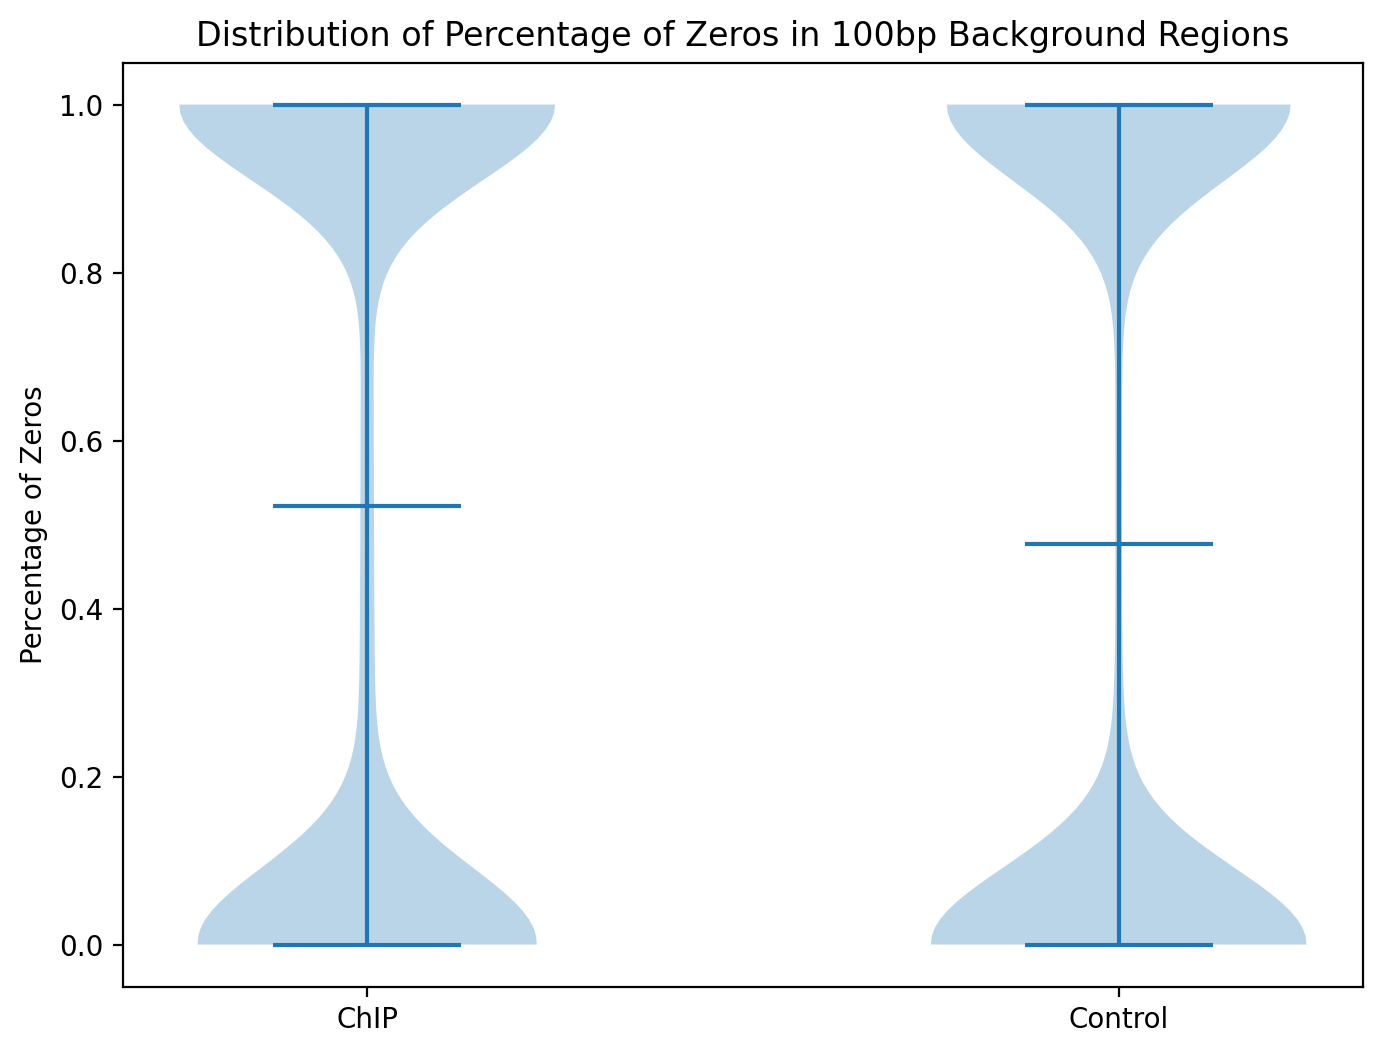

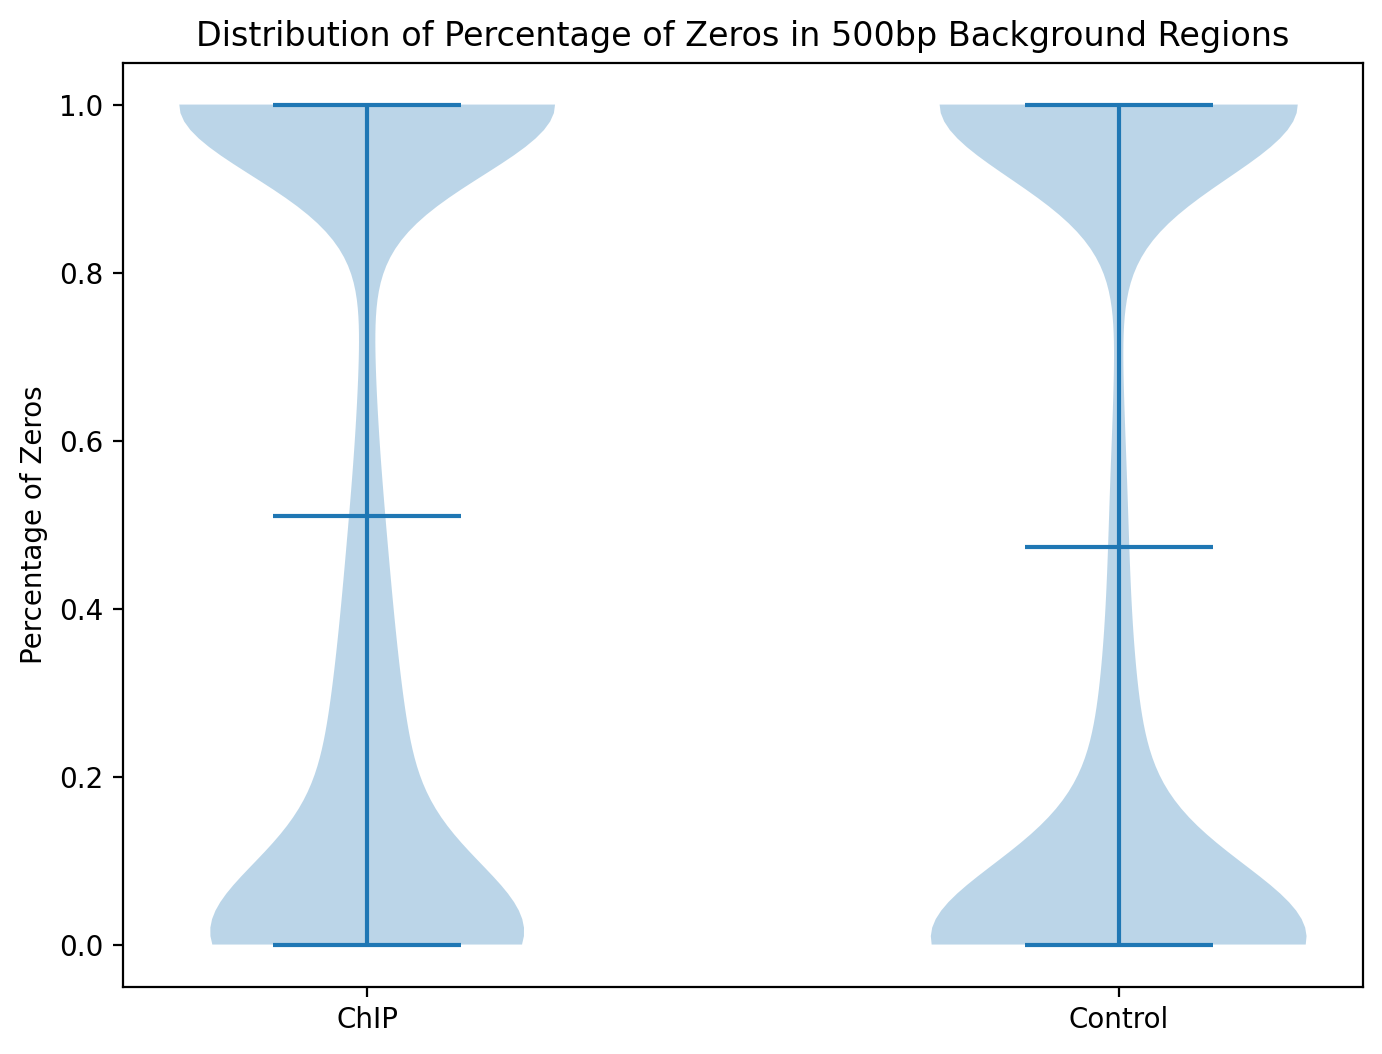

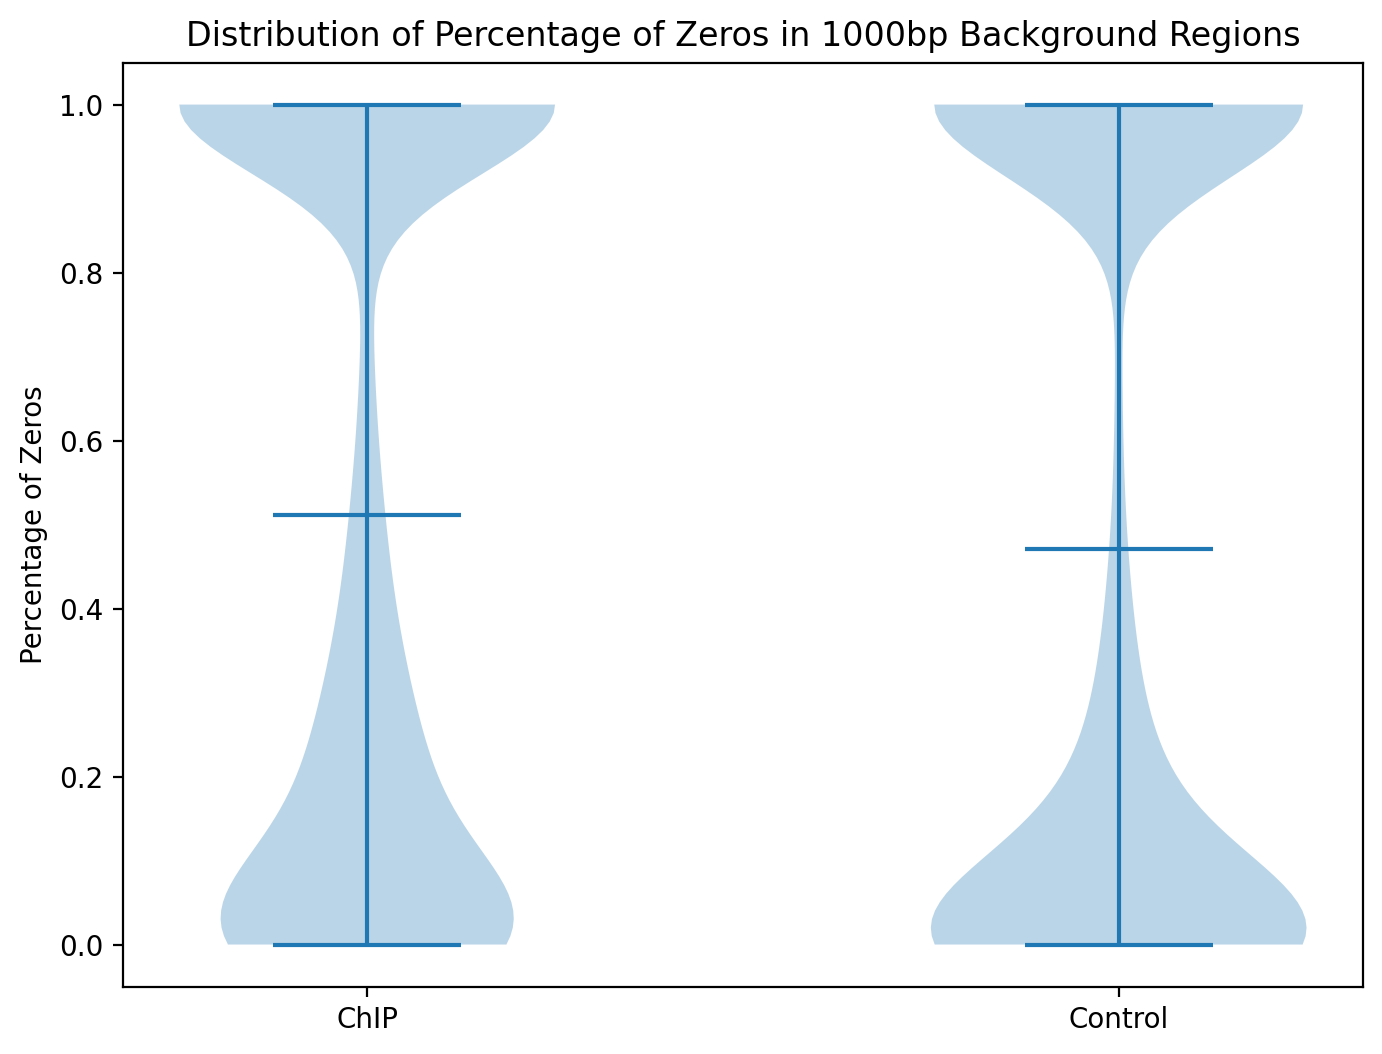

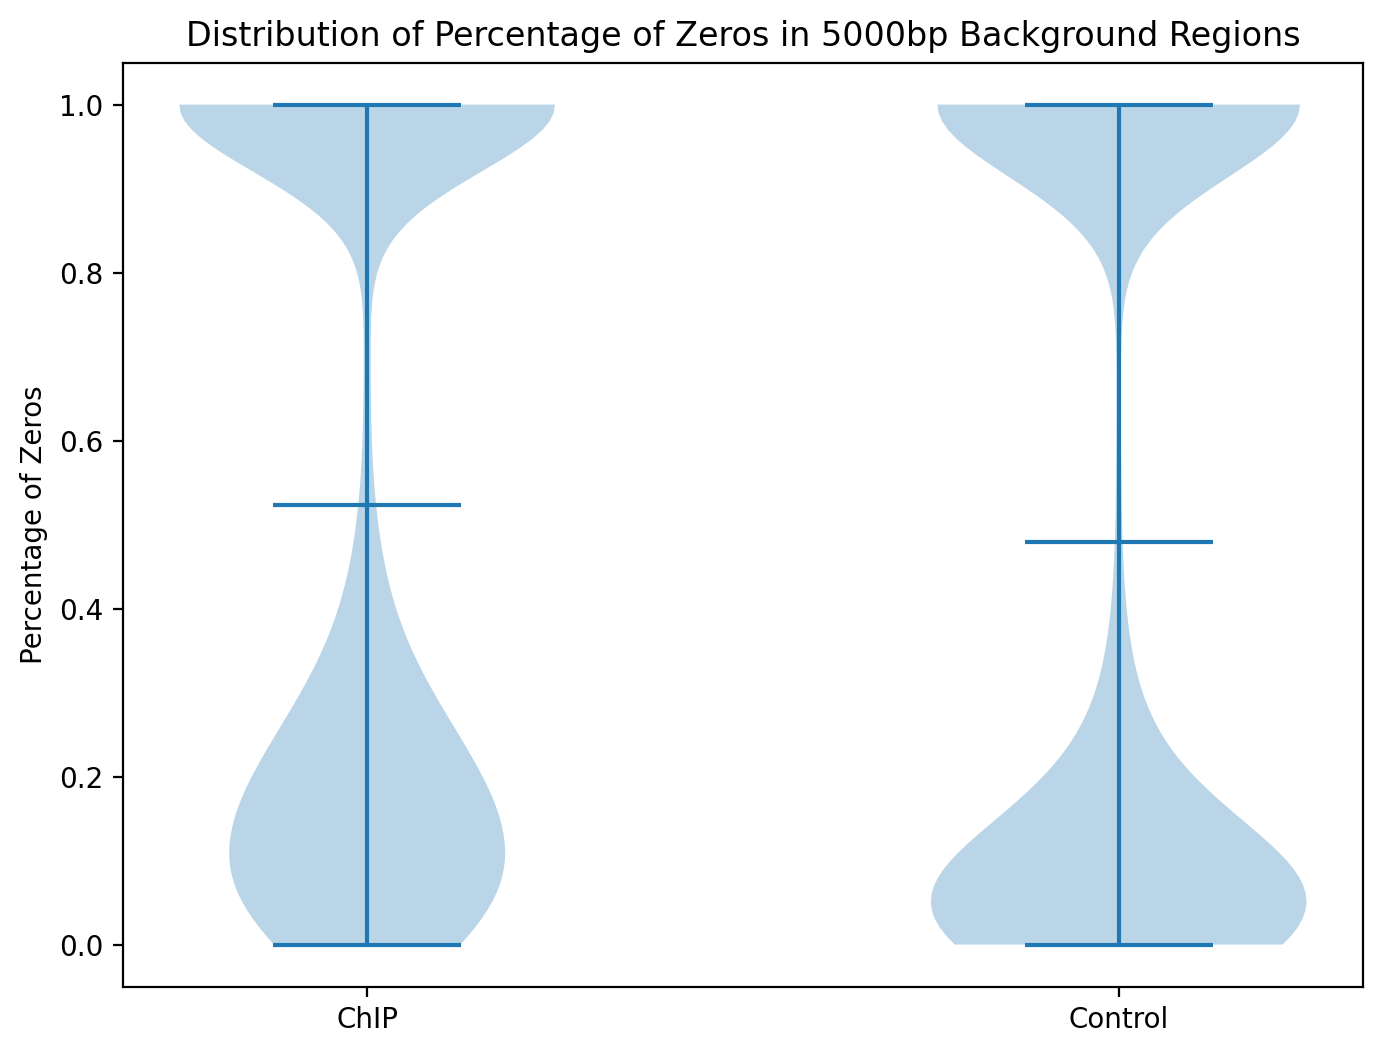

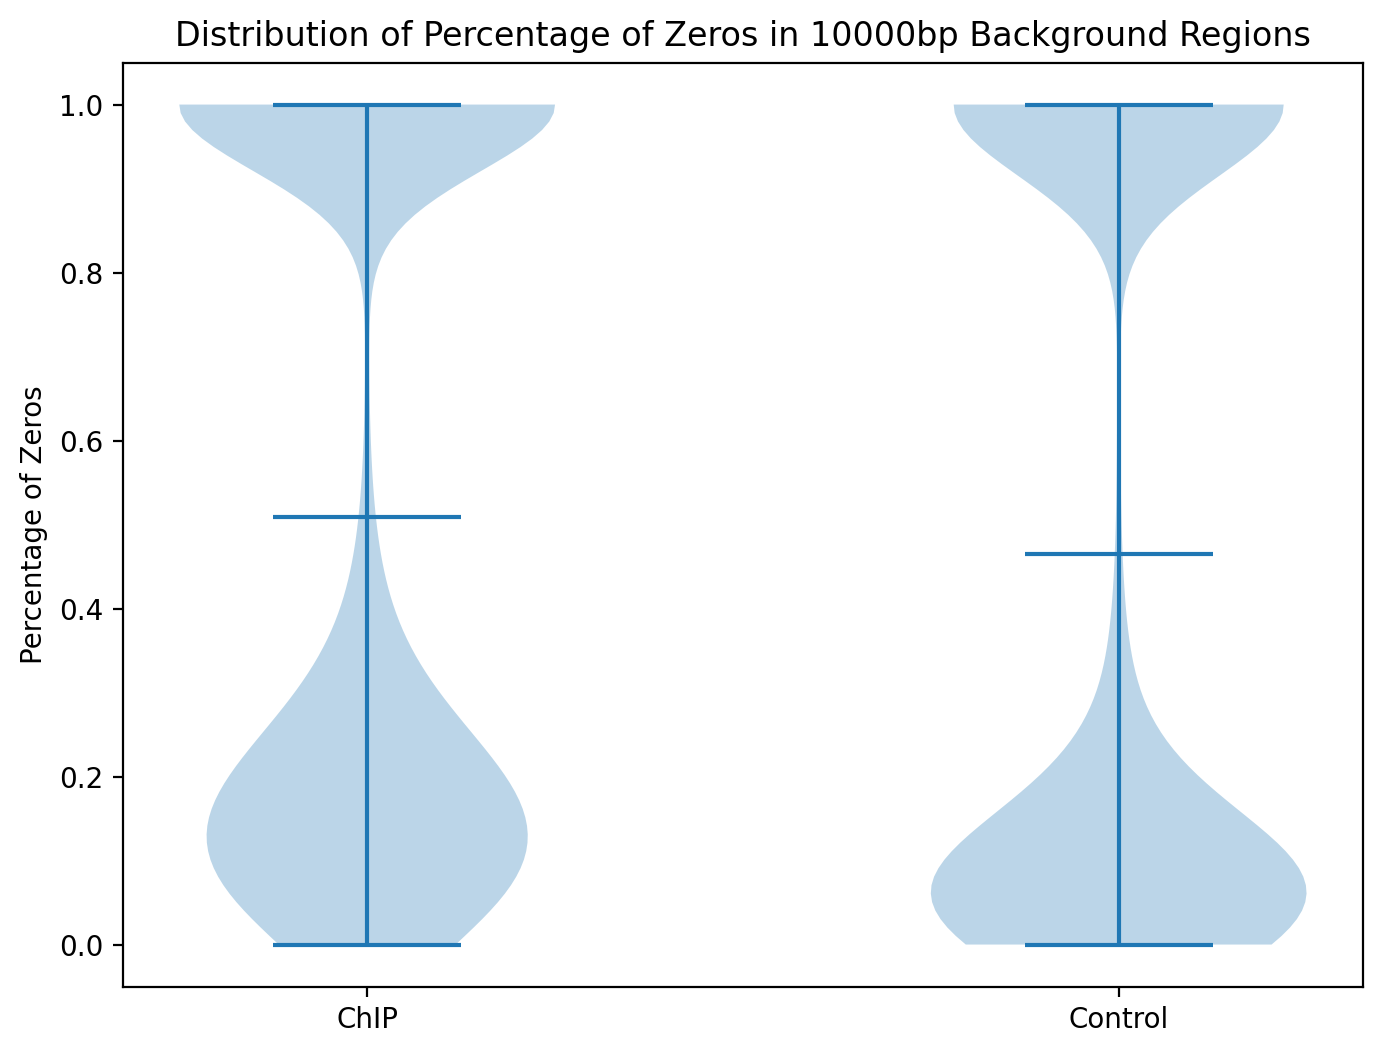

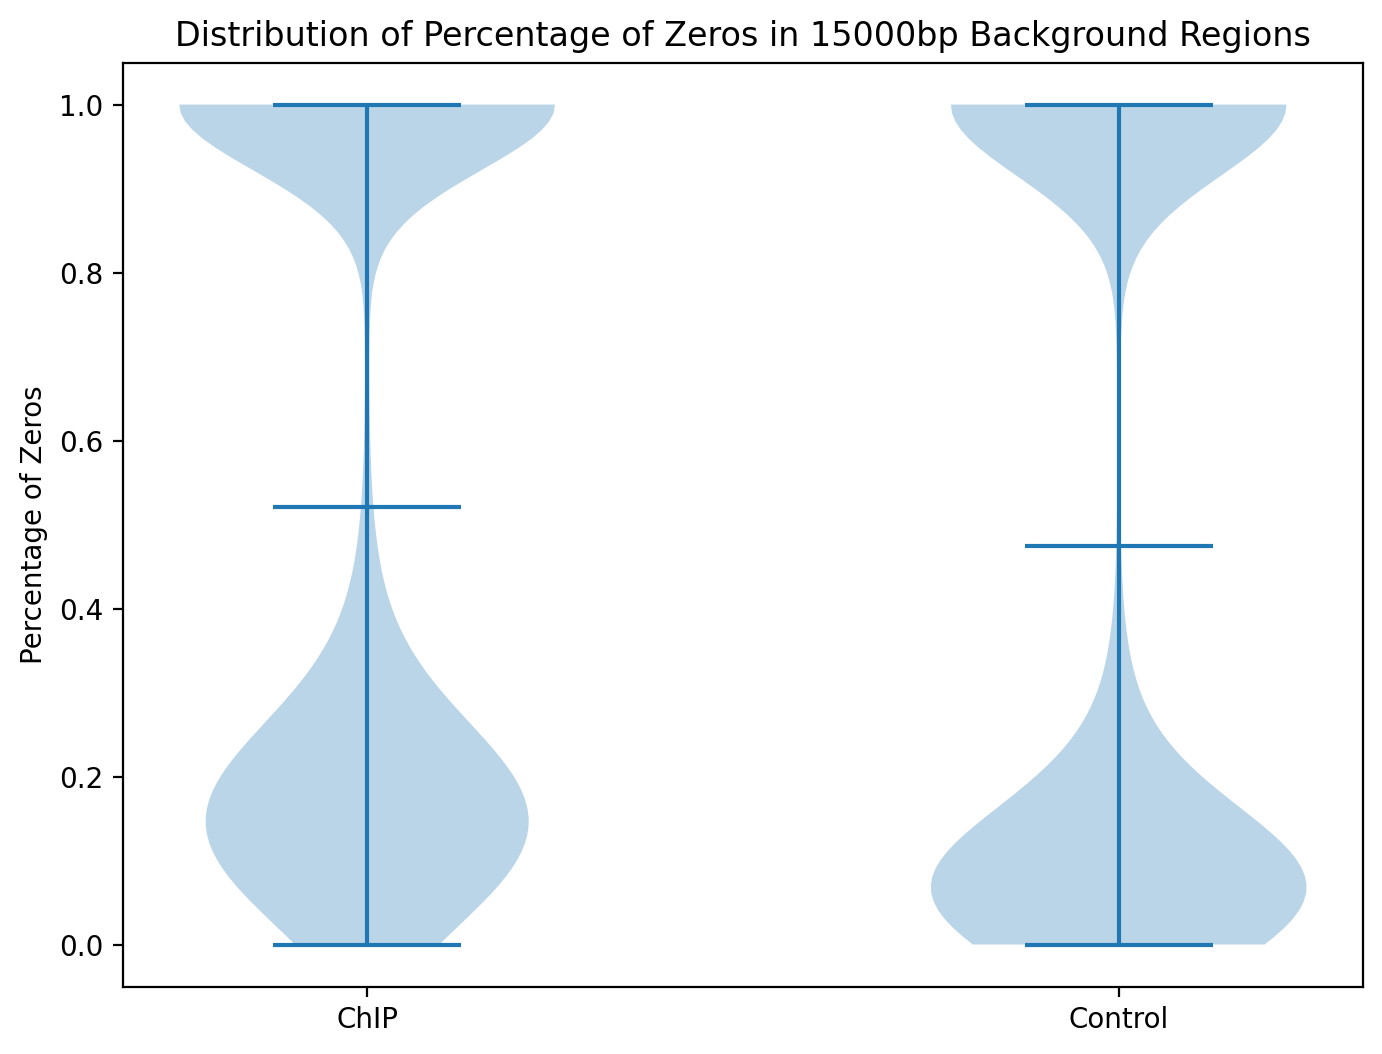

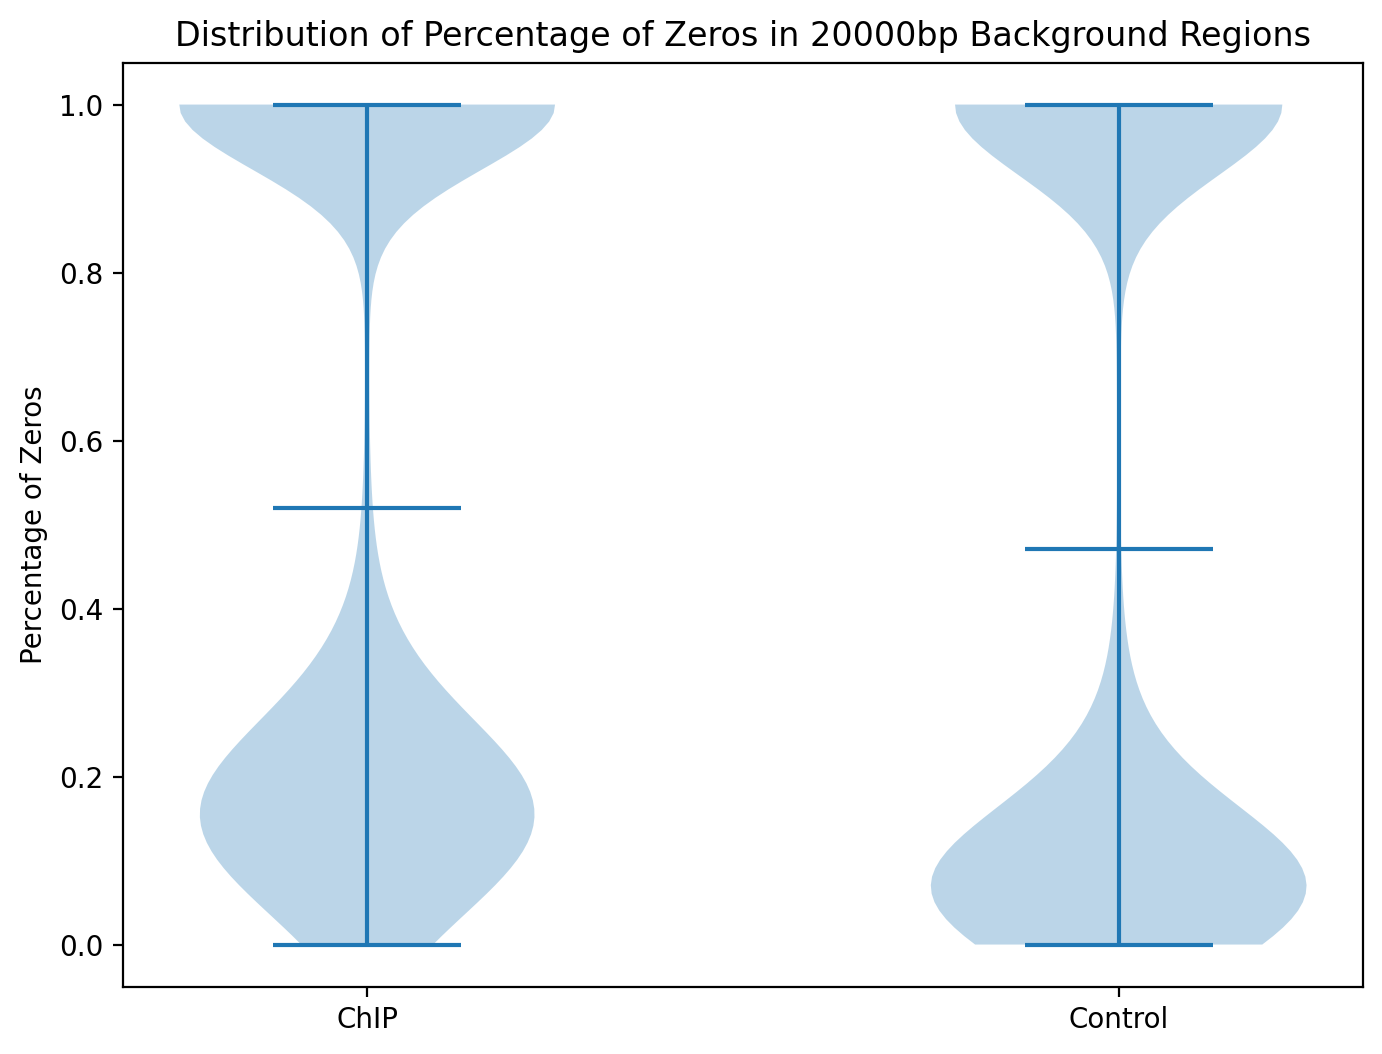

In [67]:
def run_for_L_3(L: int):
    if L == 5000:
        vals_ = vals_5k
        vals_ctrl_ = vals_ctrl_5k
    elif L == 10000:
        vals_ = vals_10k
        vals_ctrl_ = vals_ctrl_10k
    elif L == 15000:
        vals_ = vals_15k
        vals_ctrl_ = vals_ctrl_15k
    elif L == 1000:
        vals_ = vals_1k
        vals_ctrl_ = vals_ctrl_1k
    elif L == 500:
        vals_ = vals_500b
        vals_ctrl_ = vals_ctrl_500b
    elif L == 100:
        vals_ = vals_100b
        vals_ctrl_ = vals_ctrl_100b
    elif L == 20000:
        vals_ = vals_20k
        vals_ctrl_ = vals_ctrl_20k
    else:
        raise ValueError("L not handled")
    # percentage of 0s across dim 1
    pct_zeros = (vals_ == 0).sum(axis=1) / vals_.shape[1]
    pct_zeros_ctrl = (vals_ctrl_ == 0).sum(axis=1) / vals_ctrl_.shape[1]
    # plot violin plots of both arrays
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    data = [pct_zeros, pct_zeros_ctrl]
    plt.violinplot(data, positions=[1, 2], showmeans=True)
    plt.xticks([1, 2], ['ChIP', 'Control'])
    plt.ylabel('Percentage of Zeros')
    plt.title(f'Distribution of Percentage of Zeros in {L}bp Background Regions')
    plt.show()

run_for_L_3(100)
run_for_L_3(500)
run_for_L_3(1000)
run_for_L_3(5000)
run_for_L_3(10000)
run_for_L_3(15000)
run_for_L_3(20000)

So I dont 100% undersnad why these disributions are bimodal. The percentage of zeros in chip seems to be (ever so) slighly higher than in control in background regions, which is what I expected. Maybe percent zeros is not the right metric for sparsity... anyway, I just wanted to validate my earlier hypothesis (that backgroudn regions are likley more sarse in chip than in (unscaled) control, and likley the reverse for peak regions). Not sure the abbove actually shows that, mais passons.

In [68]:
def run_for_L_4(L: int, bed_based: bool = False, do_log: bool = False):
    if L == 5000:
        vals_ = vals_5k if not bed_based else vals_5k_bed
        vals_ctrl_ = vals_ctrl_5k if not bed_based else vals_ctrl_5k_bed
    elif L == 10000:
        vals_ = vals_10k if not bed_based else vals_10k_bed
        vals_ctrl_ = vals_ctrl_10k if not bed_based else vals_ctrl_10k_bed
    elif L == 1000:
        vals_ = vals_1k if not bed_based else vals_1k_bed
        vals_ctrl_ = vals_ctrl_1k if not bed_based else vals_ctrl_1k_bed
    elif L == 500:
        vals_ = vals_500b if not bed_based else vals_500b_bed
        vals_ctrl_ = vals_ctrl_500b if not bed_based else vals_ctrl_500b_bed
    elif L == 100:
        vals_ = vals_100b if not bed_based else vals_100b_bed
        vals_ctrl_ = vals_ctrl_100b if not bed_based else vals_ctrl_100b_bed
    elif L == 15000:
        vals_ = vals_15k if not bed_based else vals_15k_bed
        vals_ctrl_ = vals_ctrl_15k if not bed_based else vals_ctrl_15k_bed
    elif L == 20000:
        vals_ = vals_20k if not bed_based else vals_20k_bed
        vals_ctrl_ = vals_ctrl_20k if not bed_based else vals_ctrl_20k_bed
    else:
        raise ValueError("L not handled")
    
    # scatterplot of vals vs vals_ctrl for Lbp regions
    if len(vals_.shape) > 1:
        sum_ = vals_.sum(axis=1)
        sum_ctrl_ = vals_ctrl_.sum(axis=1)
    else:
        sum_ = vals_
        sum_ctrl_ = vals_ctrl_
    # linear regress chip on control to find a suitable scaling factor
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    if do_log:
        x = np.log1p(sum_ctrl_).reshape(-1, 1)
        y = np.log1p(sum_)
    else:
        x = sum_ctrl_.reshape(-1, 1)
        y = sum_
    model.fit(x, y)
    scaling_factor = model.coef_[0]
    # add the regression line to the scatterplot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.5)
    x_vals = np.array(plt.gca().get_xlim())
    y_vals = scaling_factor * x_vals + model.intercept_
    plt.plot(x_vals, y_vals, color='red', label='Regression Line')
    plt.xlabel(f'Control Sum ({L}bp regions)')
    plt.ylabel(f'ChIP Sum ({L}bp regions)')
    type_c = 'bed-based' if bed_based else 'bigWig-based'
    plt.title(f'ChIP vs Control Sum in {L}bp Background Regions ({type_c}) with Regression Line')
    plt.legend()
    plt.show()
    print(f"Scaling factor (slope of regression line): {scaling_factor}")
    print("Intercept of regression line:", model.intercept_)

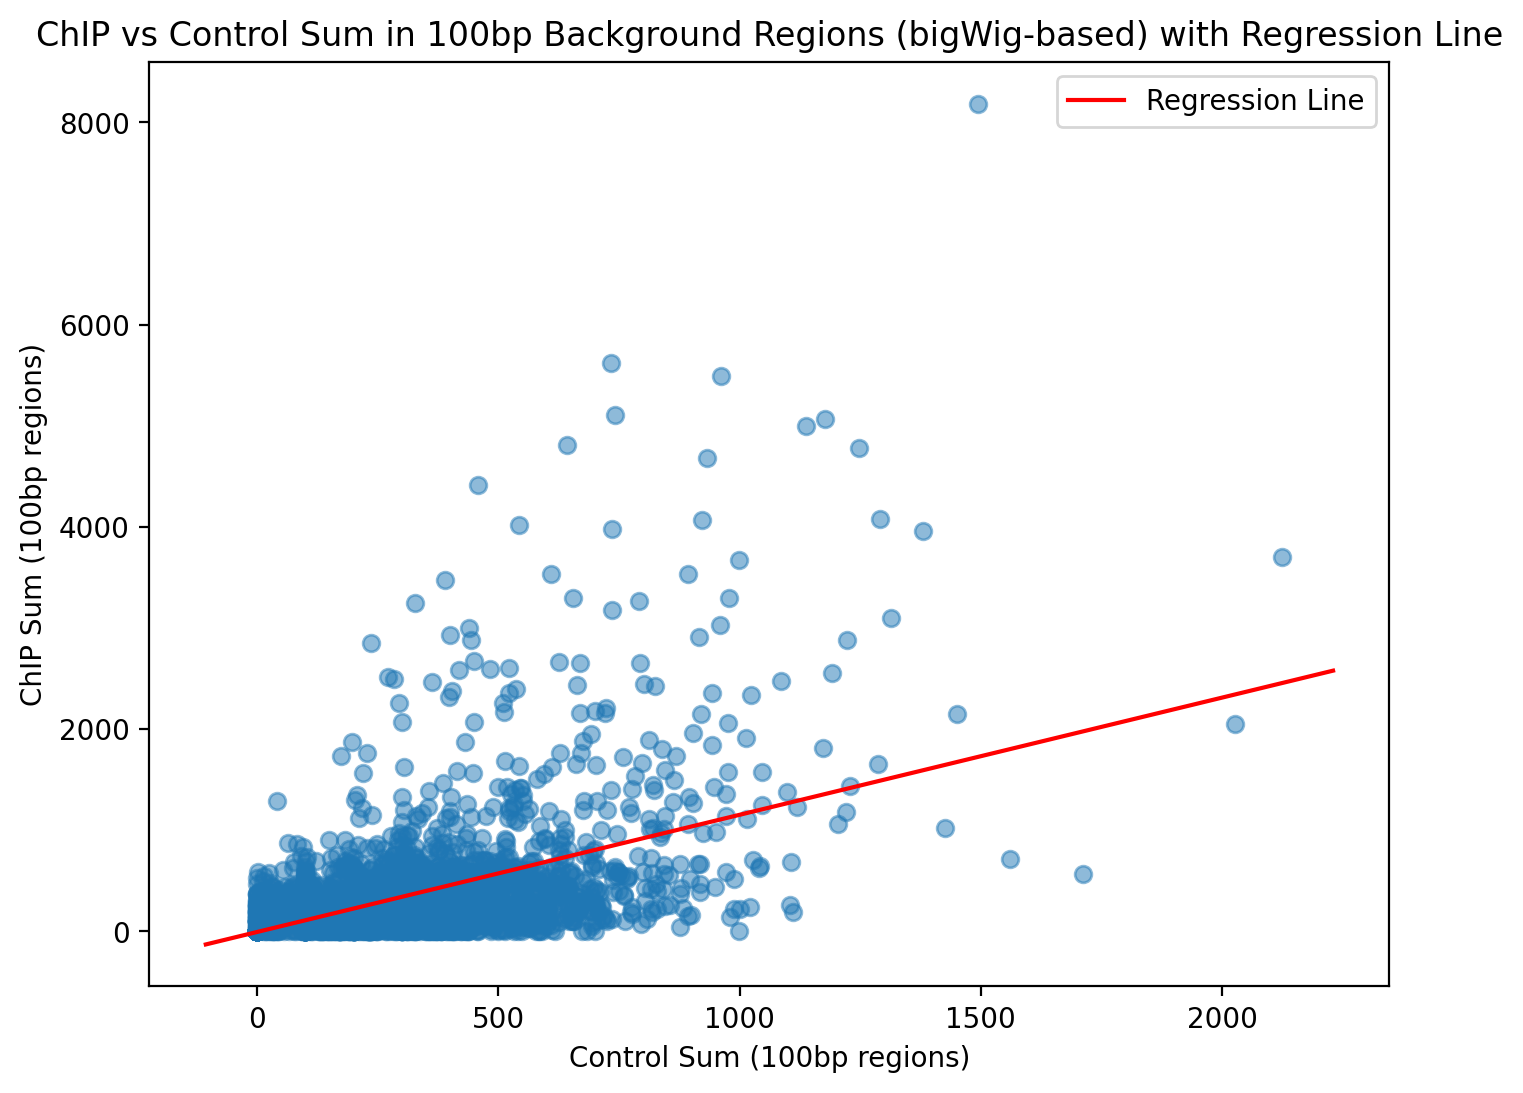

Scaling factor (slope of regression line): 1.1588244015817624
Intercept of regression line: -5.6068579521959805


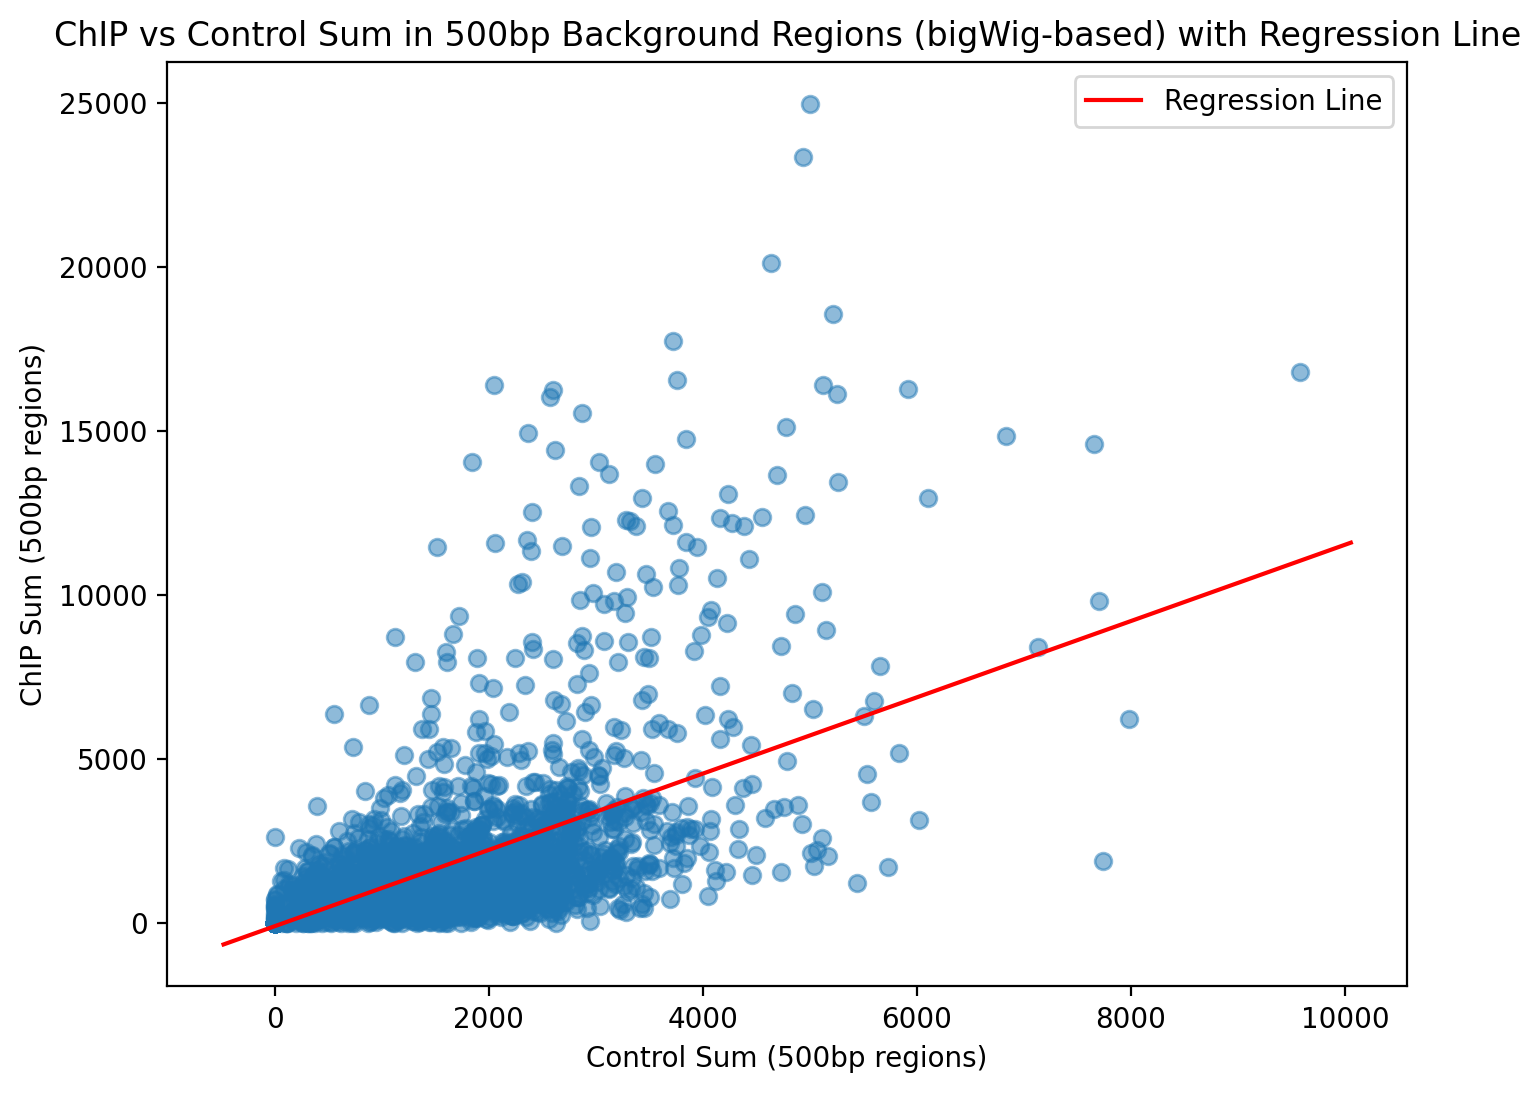

Scaling factor (slope of regression line): 1.162819068772218
Intercept of regression line: -94.92805786660062


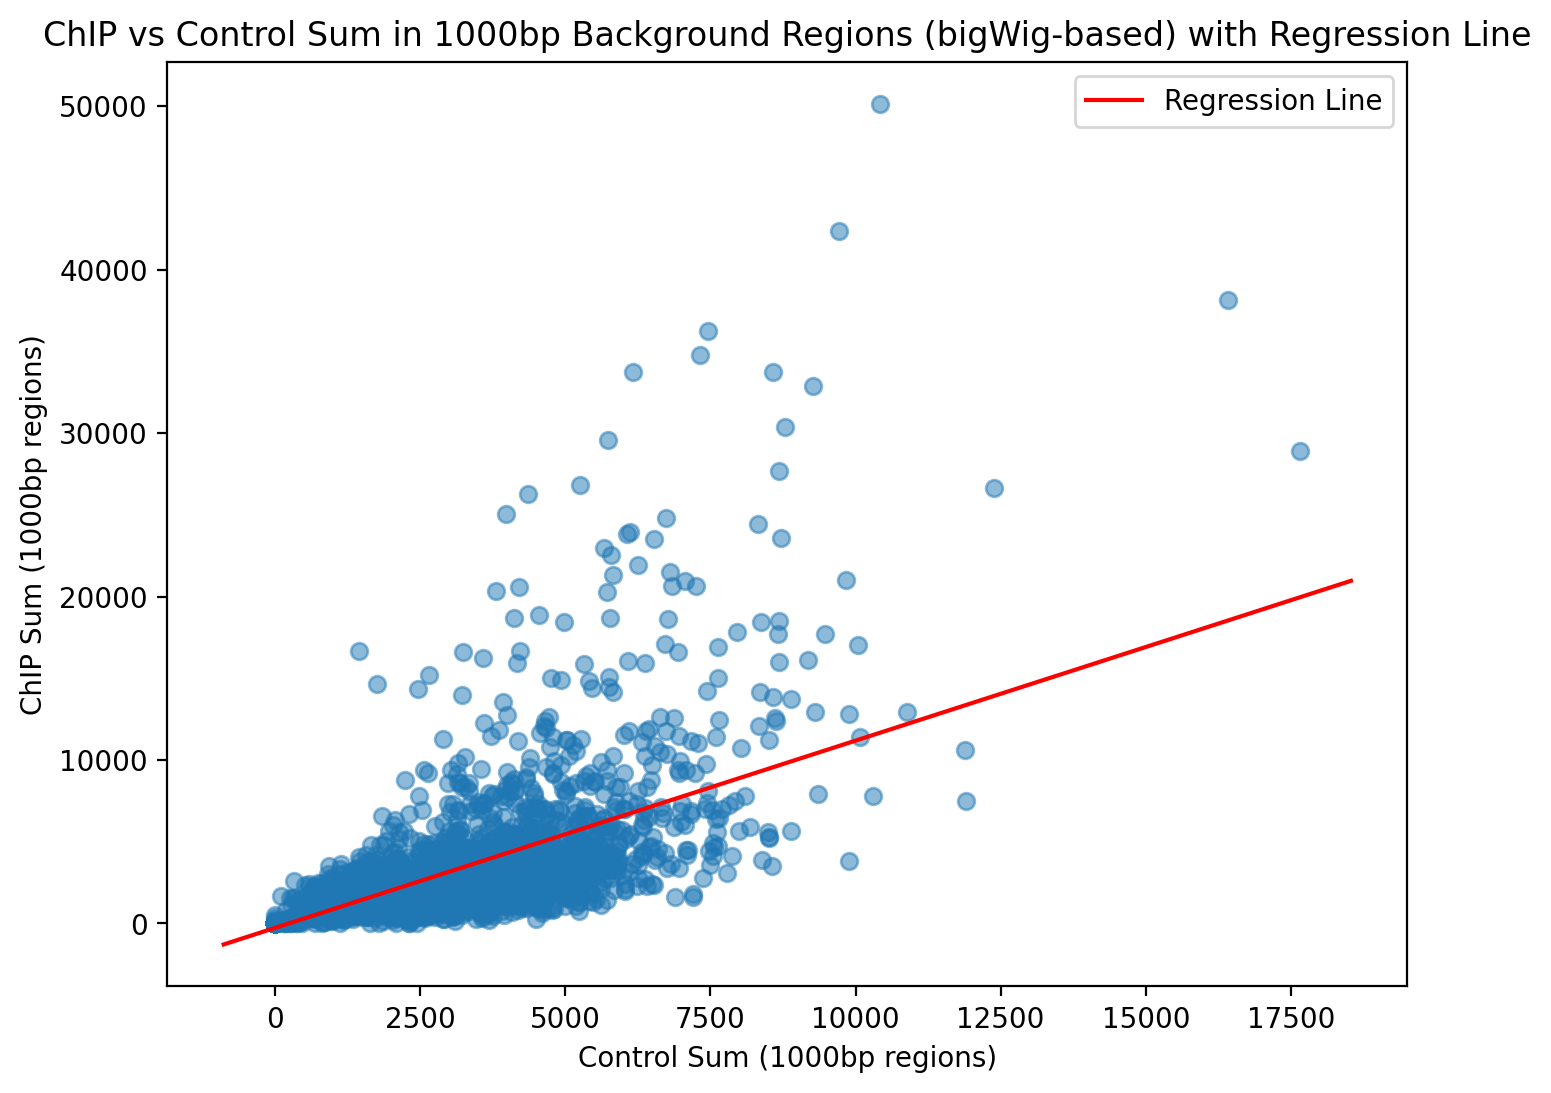

Scaling factor (slope of regression line): 1.1459757214096176
Intercept of regression line: -274.5742275311884


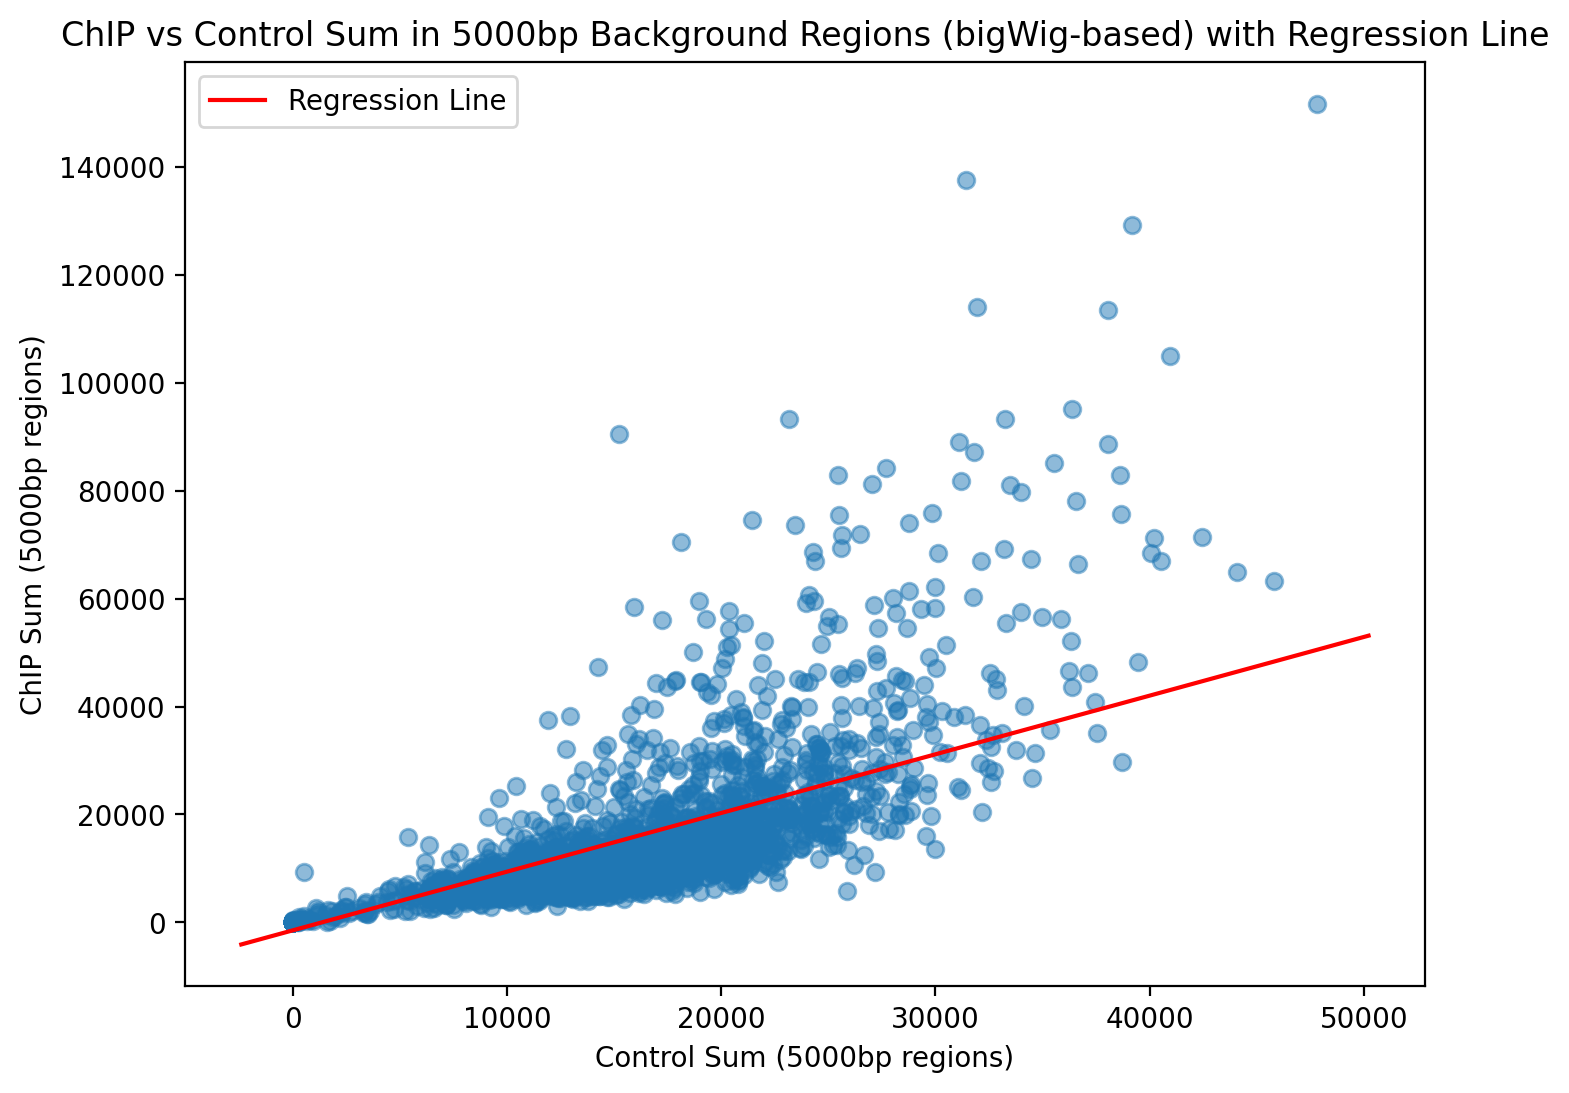

Scaling factor (slope of regression line): 1.0874460557004009
Intercept of regression line: -1480.0869628397595


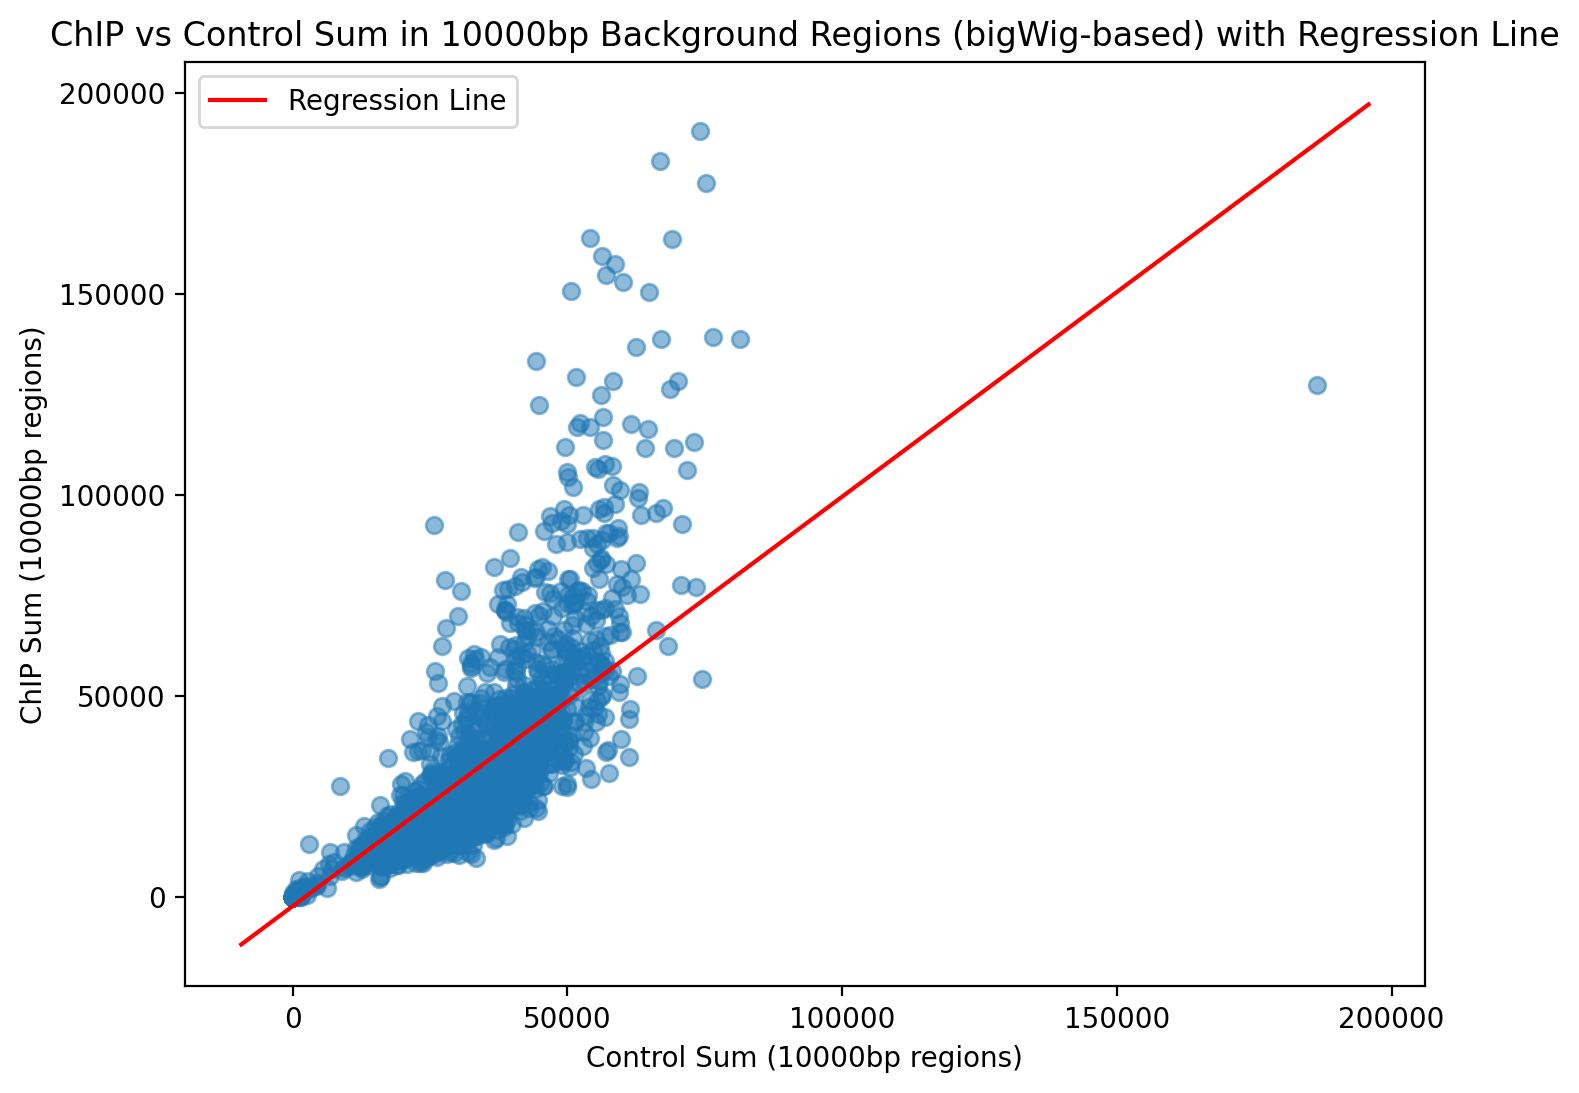

Scaling factor (slope of regression line): 1.0184537532308844
Intercept of regression line: -2369.6680409630007


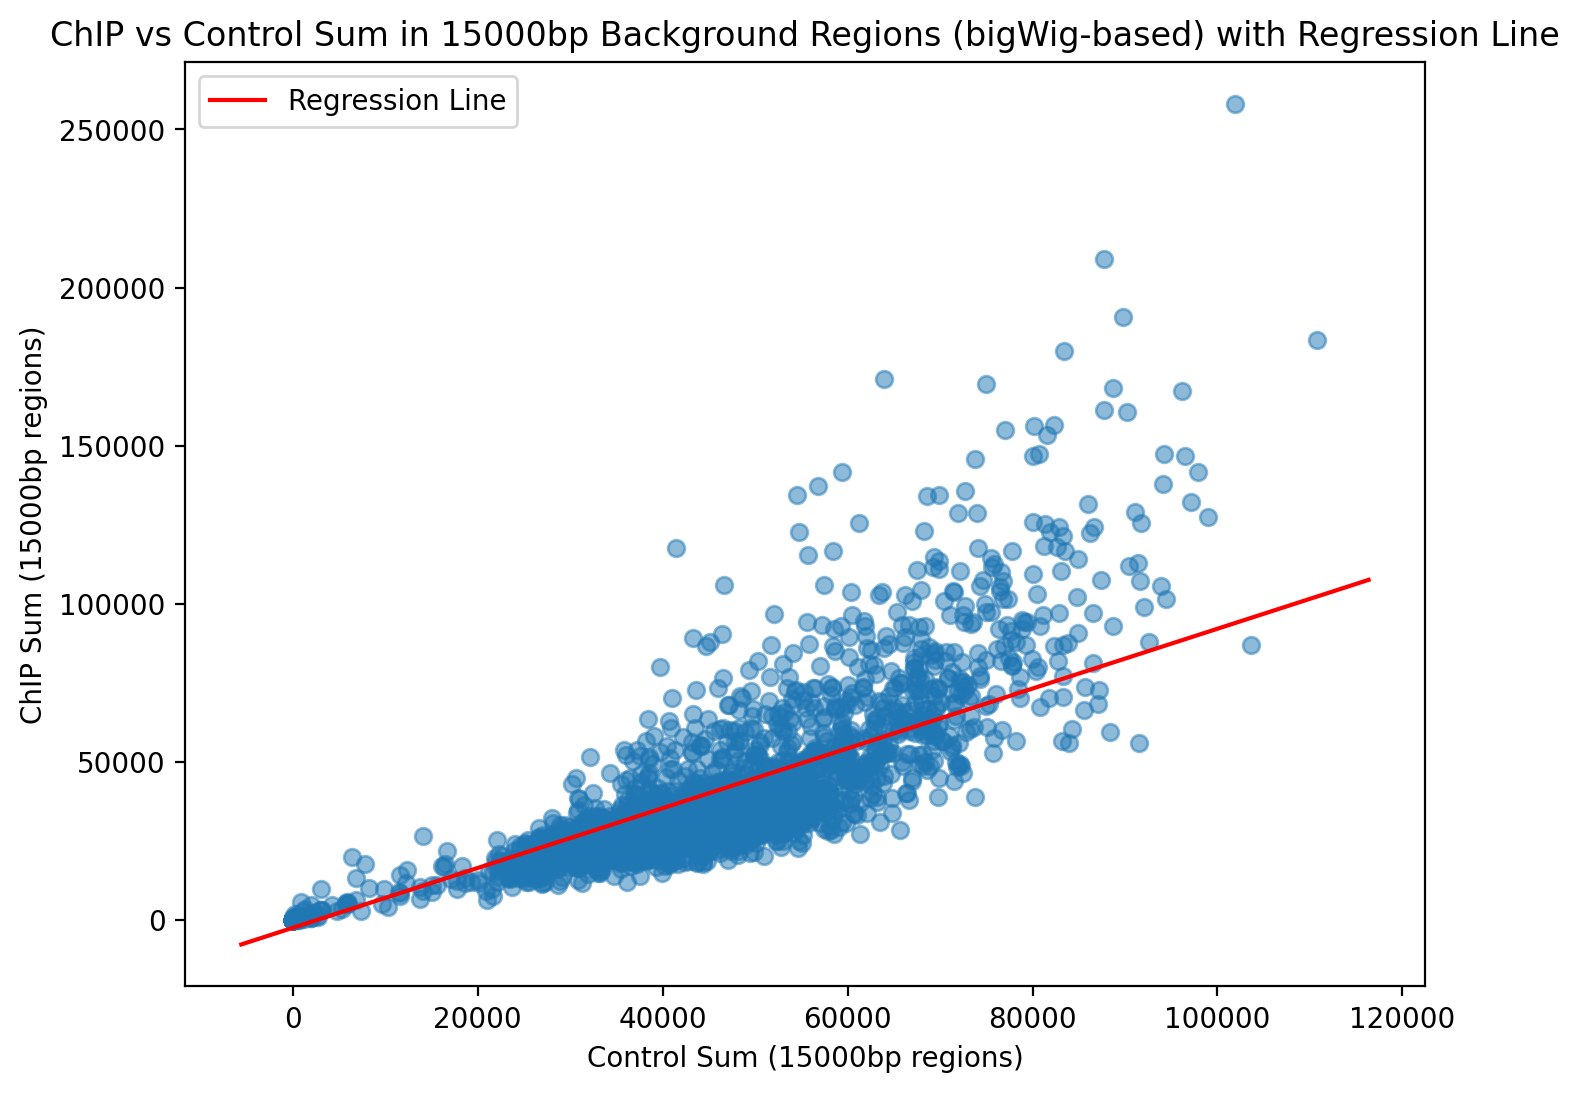

Scaling factor (slope of regression line): 0.9459269863093837
Intercept of regression line: -2476.239296459029


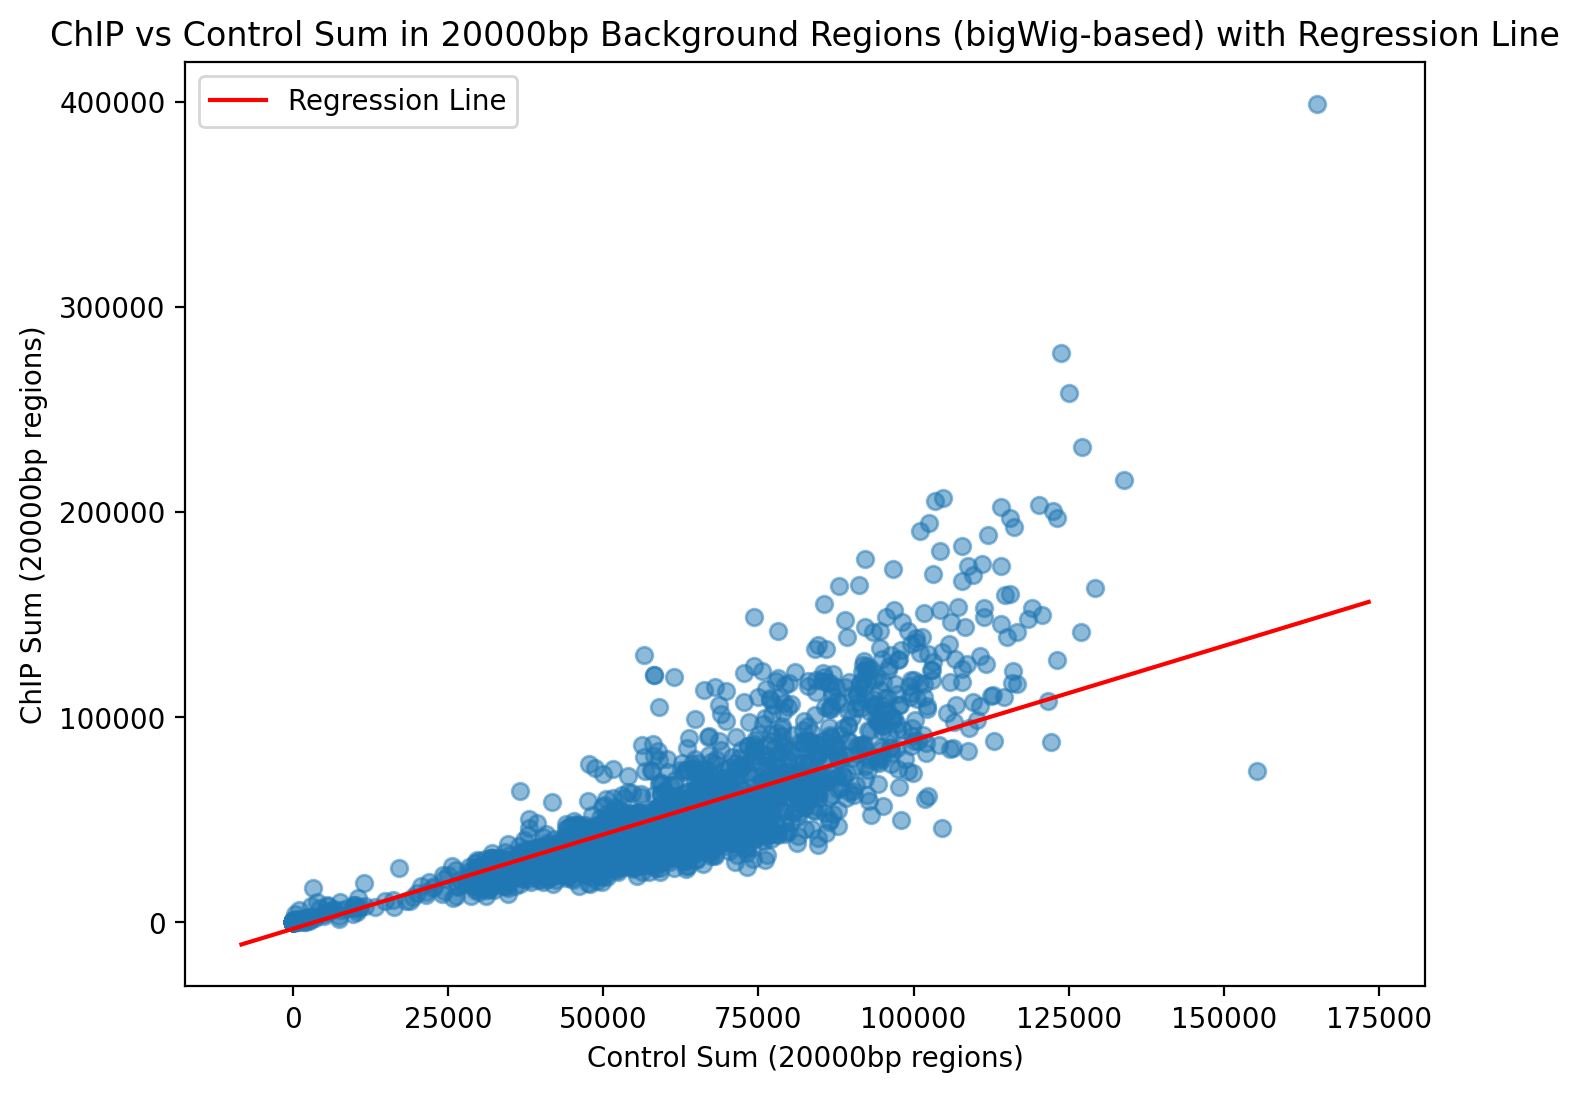

Scaling factor (slope of regression line): 0.9196961304808035
Intercept of regression line: -3122.0197983957078


In [69]:
run_for_L_4(100)
run_for_L_4(500)
run_for_L_4(1000)
run_for_L_4(5000)
run_for_L_4(10000)
run_for_L_4(15000)
run_for_L_4(20000)

## Wait..

Wait all this time I was using bigwig files which contain fragemnet pileup-based coverage values. I guess what we wanted (at least for determining the scaling factor) is more about tag count (aka fragemnet count), so I guess we should use bed files for that (though I suppose one is some function of the other, as pileup is computed based on tags/fragments).

Btw, one sec

In [ ]:
# 25267228 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/rep1/rep1.bed
# 31150520 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/rep2/rep2.bed
# 26654427 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/rep3/rep3.bed
# (hist6) GPU3694 :: ~/projects/toolbox ‹main*› » zcat /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/rep4/rep4.bed.gz | wc -l 
# 76901233

In [89]:
25267228 + 31150520 + 26654427 + 76901233

159973408

In [90]:
34853714 / 159973408

0.21787192281357162

The scaling factor according to total read count is 5, per teh above ^

In [70]:
def run_for_L_5(L: int):
    if L == 5000:
        df = df_5kb
    elif L == 10000:
        df = df_10kb
    elif L == 1000:
        df = df_1kb
    elif L == 500:
        df = df_500b
    elif L == 100:
        df = df_100b
    elif L == 15000:
        df = df_15kb
    elif L == 20000:
        df = df_20kb
    else:
        raise ValueError("L not handled")
    def count_reads_in_bed(bed_file: str, chrom: str, start: int, end: int) -> int:
        # tabix uses 0-based, half-open coordinates like BED
        cmd = f"tabix {bed_file} {chrom}:{start}-{end} | wc -l"
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True, check=True)
        return int(result.stdout.strip())
    vals = []
    vals_ctrl = []
    for _, r in df.iterrows():
        # read number of reads in chip and control bed files
        chip_reads = count_reads_in_bed(chip_bed, r['chrom'], r['start'], r['end'])
        ctrl_reads = count_reads_in_bed(ctrl_bed, r['chrom'], r['start'], r['end'])
        vals.append(chip_reads)
        vals_ctrl.append(ctrl_reads)
    vals = np.array(vals)
    vals_ctrl = np.array(vals_ctrl)
    return vals, vals_ctrl

# if not os.path.isfile("vals_100b.npy") or not os.path.isfile("vals_ctrl_100b.npy"):
#     vals_100b_bed, vals_ctrl_100b_bed = run_for_L_5(100)
#     np.save("vals_100b.npy", vals_100b_bed)
#     np.save("vals_ctrl_100b.npy", vals_ctrl_100b_bed)
# else:
#     vals_100b_bed = np.load("vals_100b.npy")
#     vals_ctrl_100b_bed = np.load("vals_ctrl_100b.npy")

# if not os.path.isfile("vals_500b.npy") or not os.path.isfile("vals_ctrl_500b.npy"):
#     vals_500b_bed, vals_ctrl_500b_bed = run_for_L_5(500)
#     np.save("vals_500b.npy", vals_500b_bed)
#     np.save("vals_ctrl_500b.npy", vals_ctrl_500b_bed)
# else:
#     vals_500b_bed = np.load("vals_500b.npy")
#     vals_ctrl_500b_bed = np.load("vals_ctrl_500b.npy")

# if not os.path.isfile("vals_1k.npy") or not os.path.isfile("vals_ctrl_1k.npy"):
#     vals_1k_bed, vals_ctrl_1k_bed = run_for_L_5(1000)
#     np.save("vals_1k.npy", vals_1k_bed)
#     np.save("vals_ctrl_1k.npy", vals_ctrl_1k_bed)
# else:
#     vals_1k_bed = np.load("vals_1k.npy")
#     vals_ctrl_1k_bed = np.load("vals_ctrl_1k.npy")

# if not os.path.isfile("vals_5k.npy") or not os.path.isfile("vals_ctrl_5k.npy"):
#     vals_5k_bed, vals_ctrl_5k_bed = run_for_L_5(5000)
#     np.save("vals_5k.npy", vals_5k_bed)
#     np.save("vals_ctrl_5k.npy", vals_ctrl_5k_bed)
# else:
#     vals_5k_bed = np.load("vals_5k.npy")
#     vals_ctrl_5k_bed = np.load("vals_ctrl_5k.npy")

# if not os.path.isfile("vals_10k.npy") or not os.path.isfile("vals_ctrl_10k.npy"):
#     vals_10k_bed, vals_ctrl_10k_bed = run_for_L_5(10000)
#     np.save("vals_10k.npy", vals_10k_bed)
#     np.save("vals_ctrl_10k.npy", vals_ctrl_10k_bed)
# else:
#     vals_10k_bed = np.load("vals_10k.npy")
#     vals_ctrl_10k_bed = np.load("vals_ctrl_10k.npy")

# if not os.path.isfile("vals_15k.npy") or not os.path.isfile("vals_ctrl_15k.npy"):
#     vals_15k_bed, vals_ctrl_15k_bed = run_for_L_5(15000)
#     np.save("vals_15k.npy", vals_15k_bed)
#     np.save("vals_ctrl_15k.npy", vals_ctrl_15k_bed)
# else:
#     vals_15k_bed = np.load("vals_15k.npy")
#     vals_ctrl_15k_bed = np.load("vals_ctrl_15k.npy")

if not os.path.isfile("vals_20k.npy") or not os.path.isfile("vals_ctrl_20k.npy"):
    vals_20k_bed, vals_ctrl_20k_bed = run_for_L_5(20000)
    np.save("vals_20k.npy", vals_20k_bed)
    np.save("vals_ctrl_20k.npy", vals_ctrl_20k_bed)
else:
    vals_20k_bed = np.load("vals_20k.npy")
    vals_ctrl_20k_bed = np.load("vals_ctrl_20k.npy")

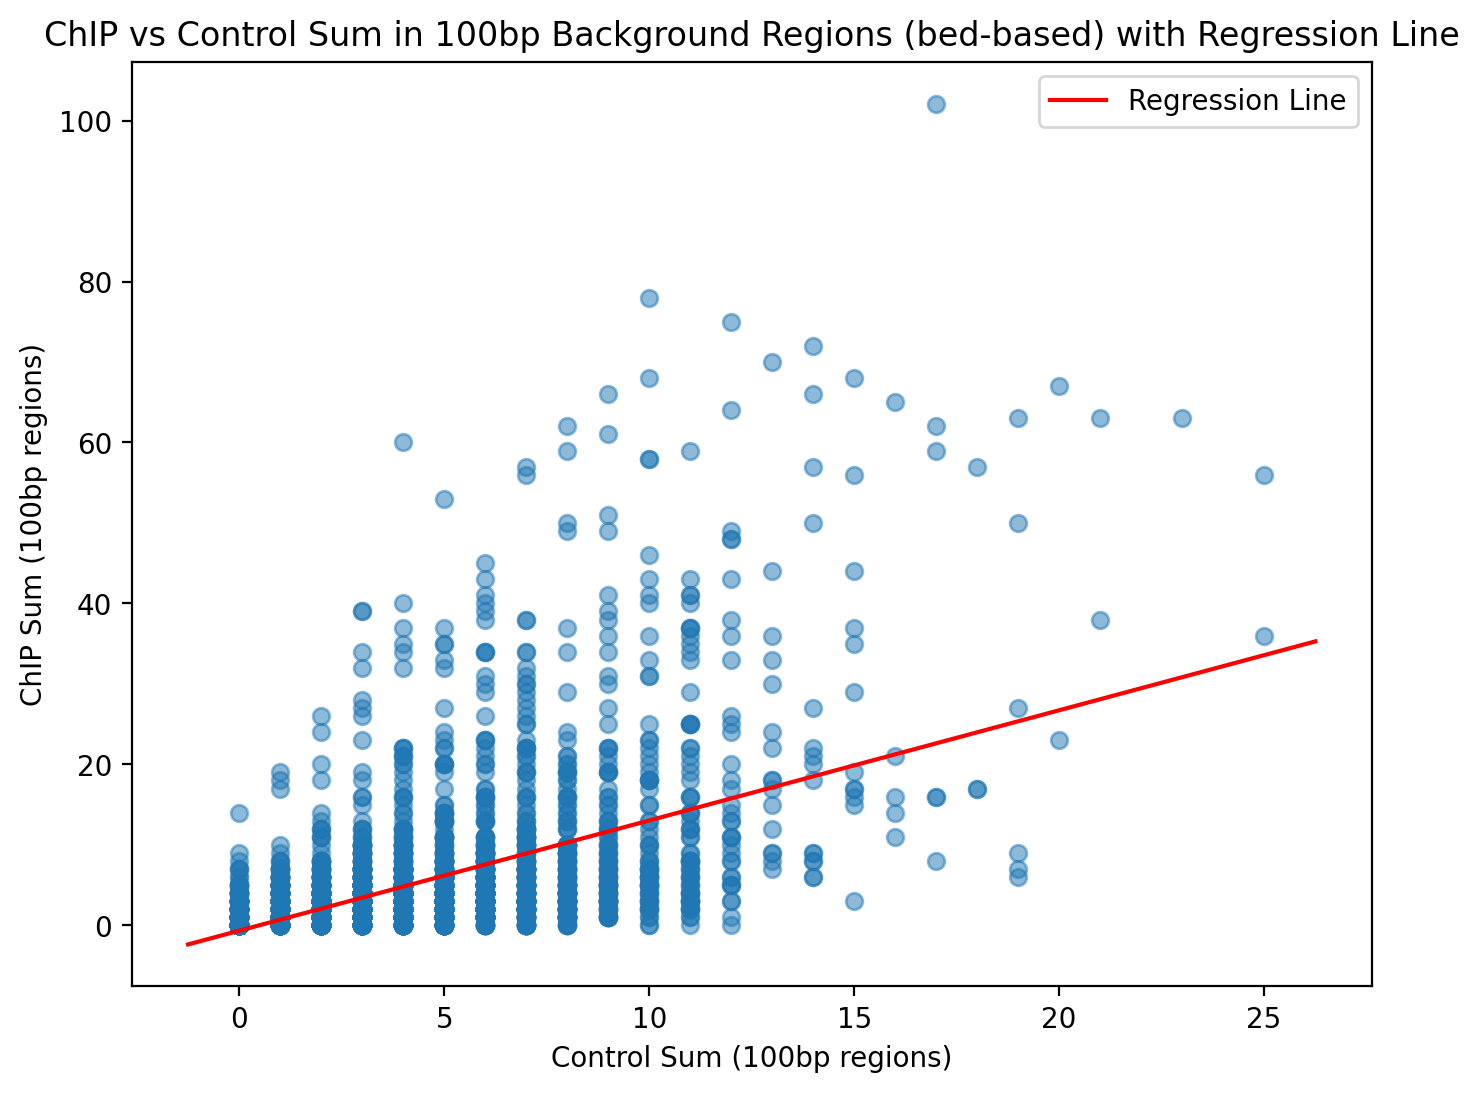

Scaling factor (slope of regression line): 1.3692790350269362
Intercept of regression line: -0.6611920166645797


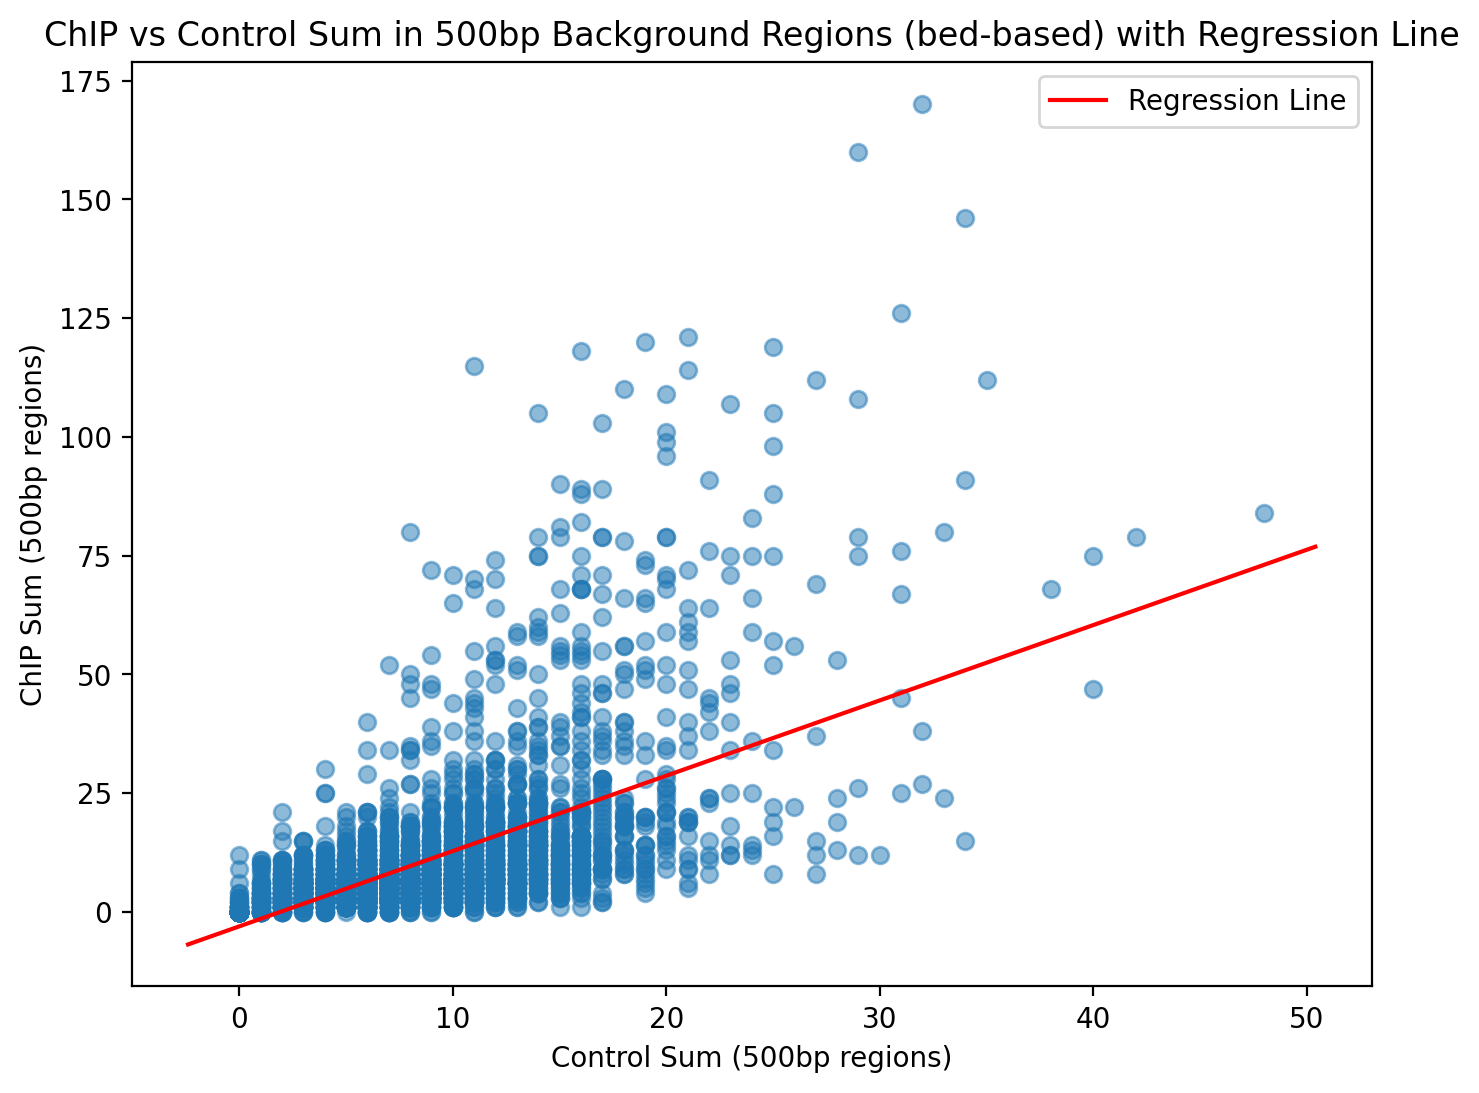

Scaling factor (slope of regression line): 1.585743916694039
Intercept of regression line: -3.033162024118875


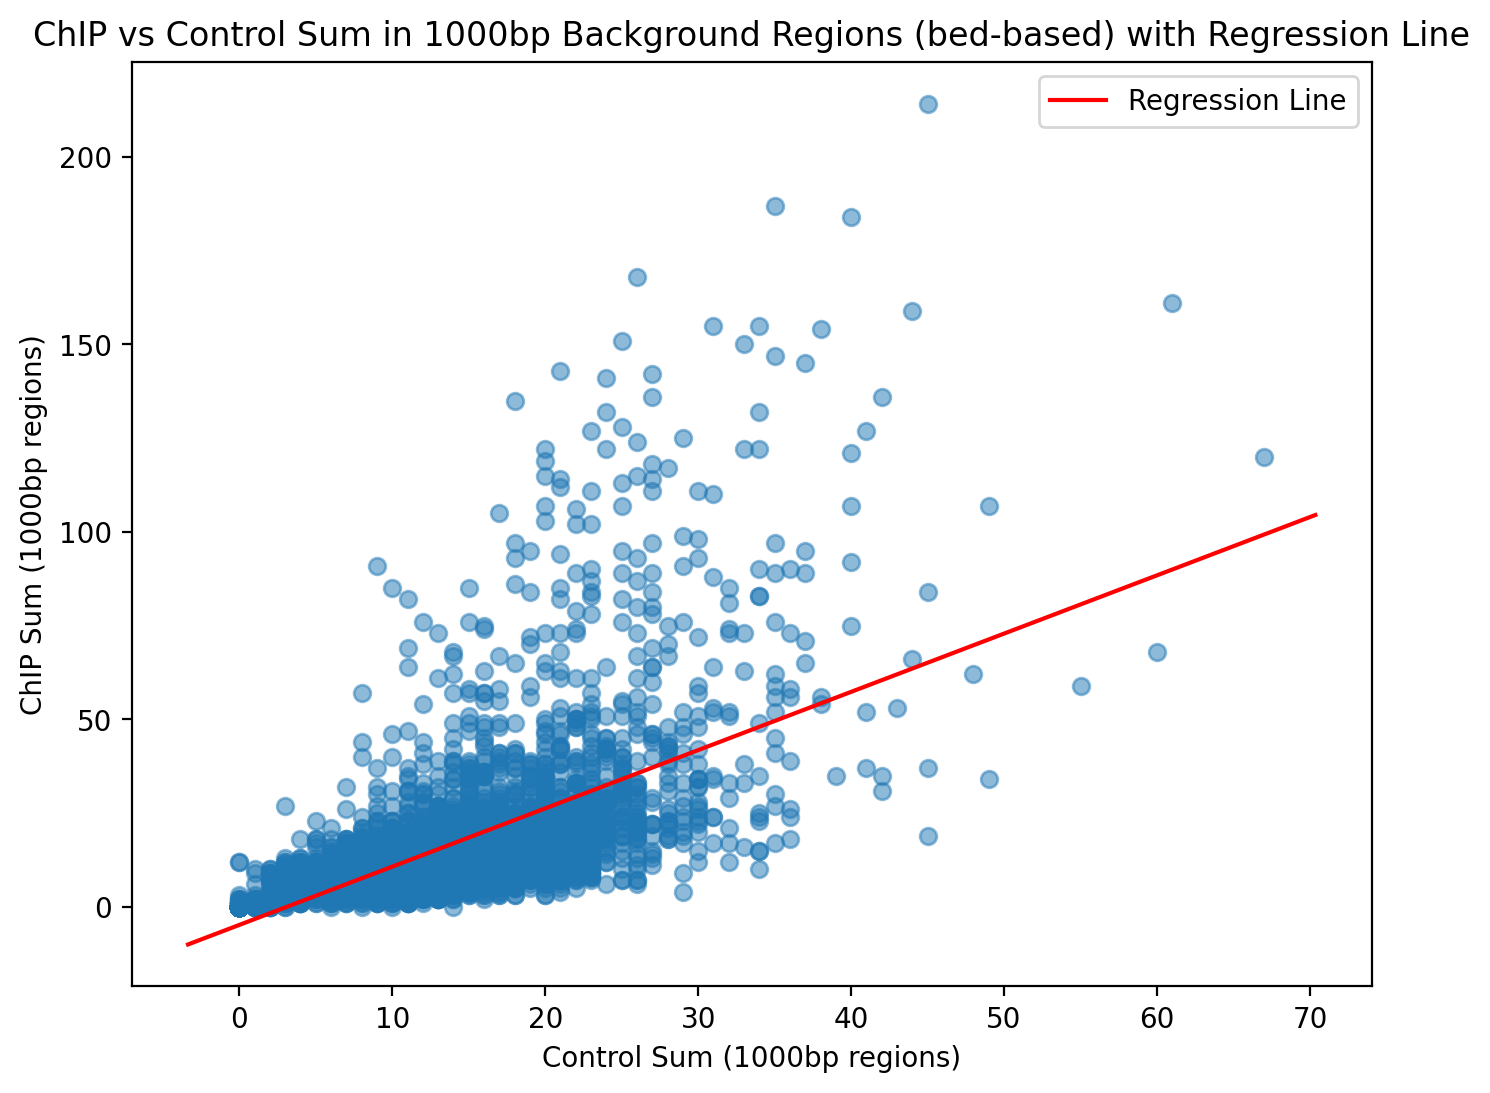

Scaling factor (slope of regression line): 1.5541633789725868
Intercept of regression line: -4.850922337491983


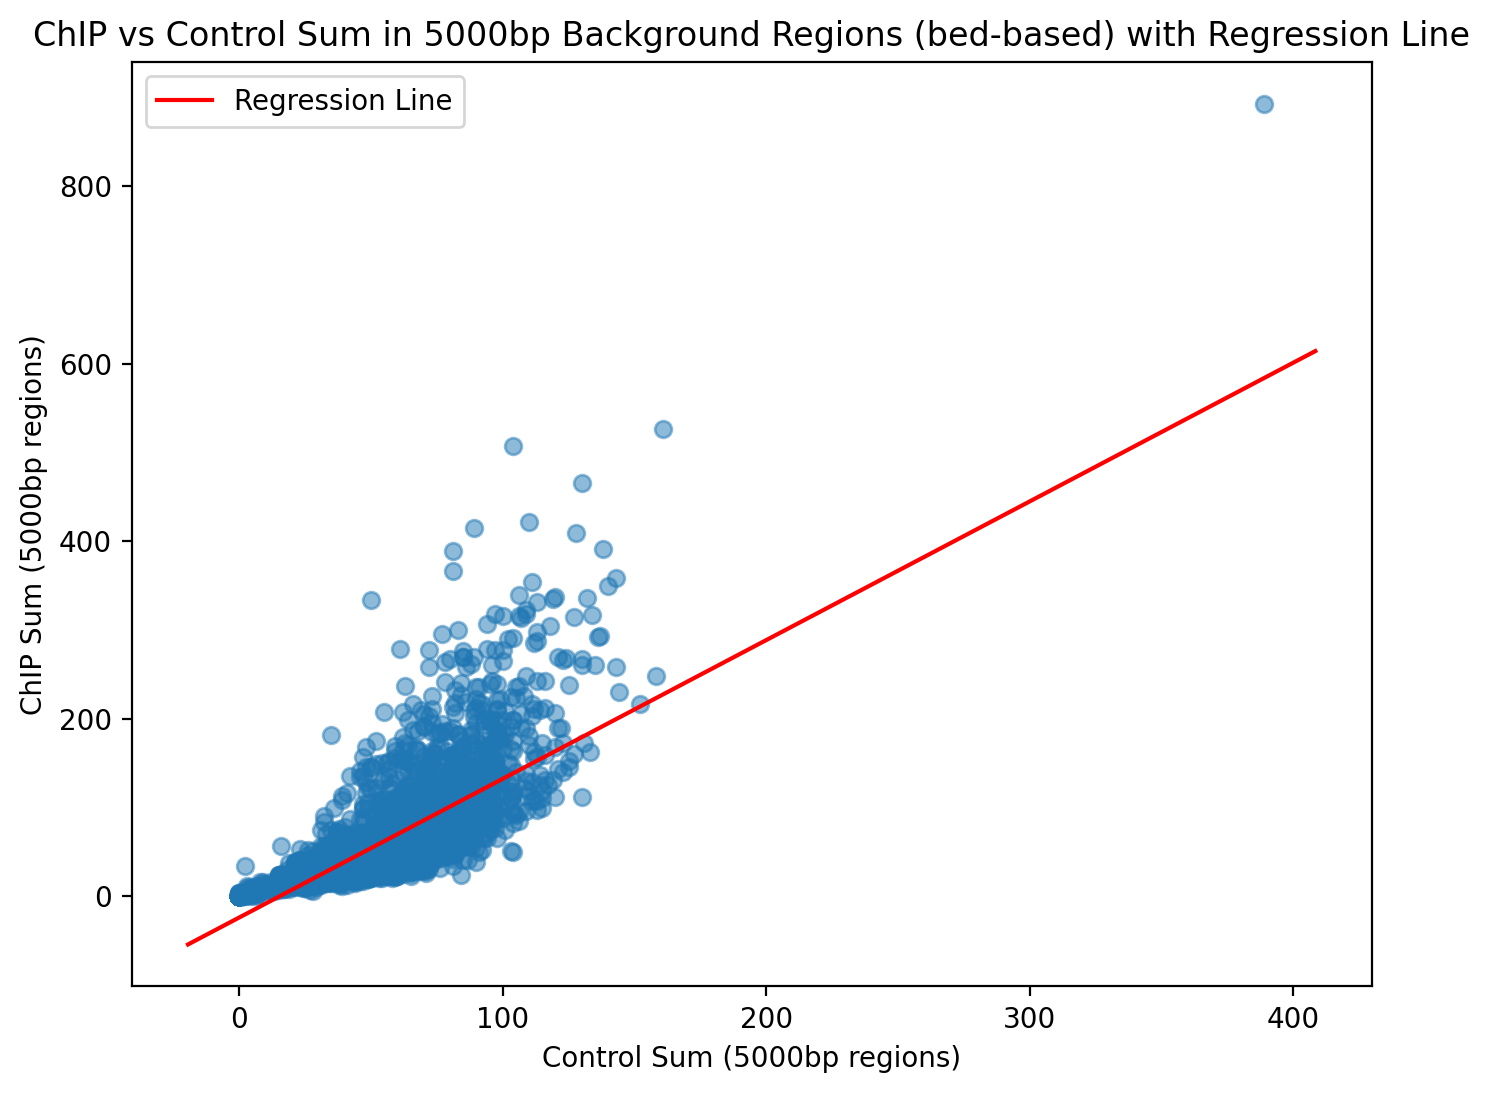

Scaling factor (slope of regression line): 1.5623319325513818
Intercept of regression line: -24.030977909102134


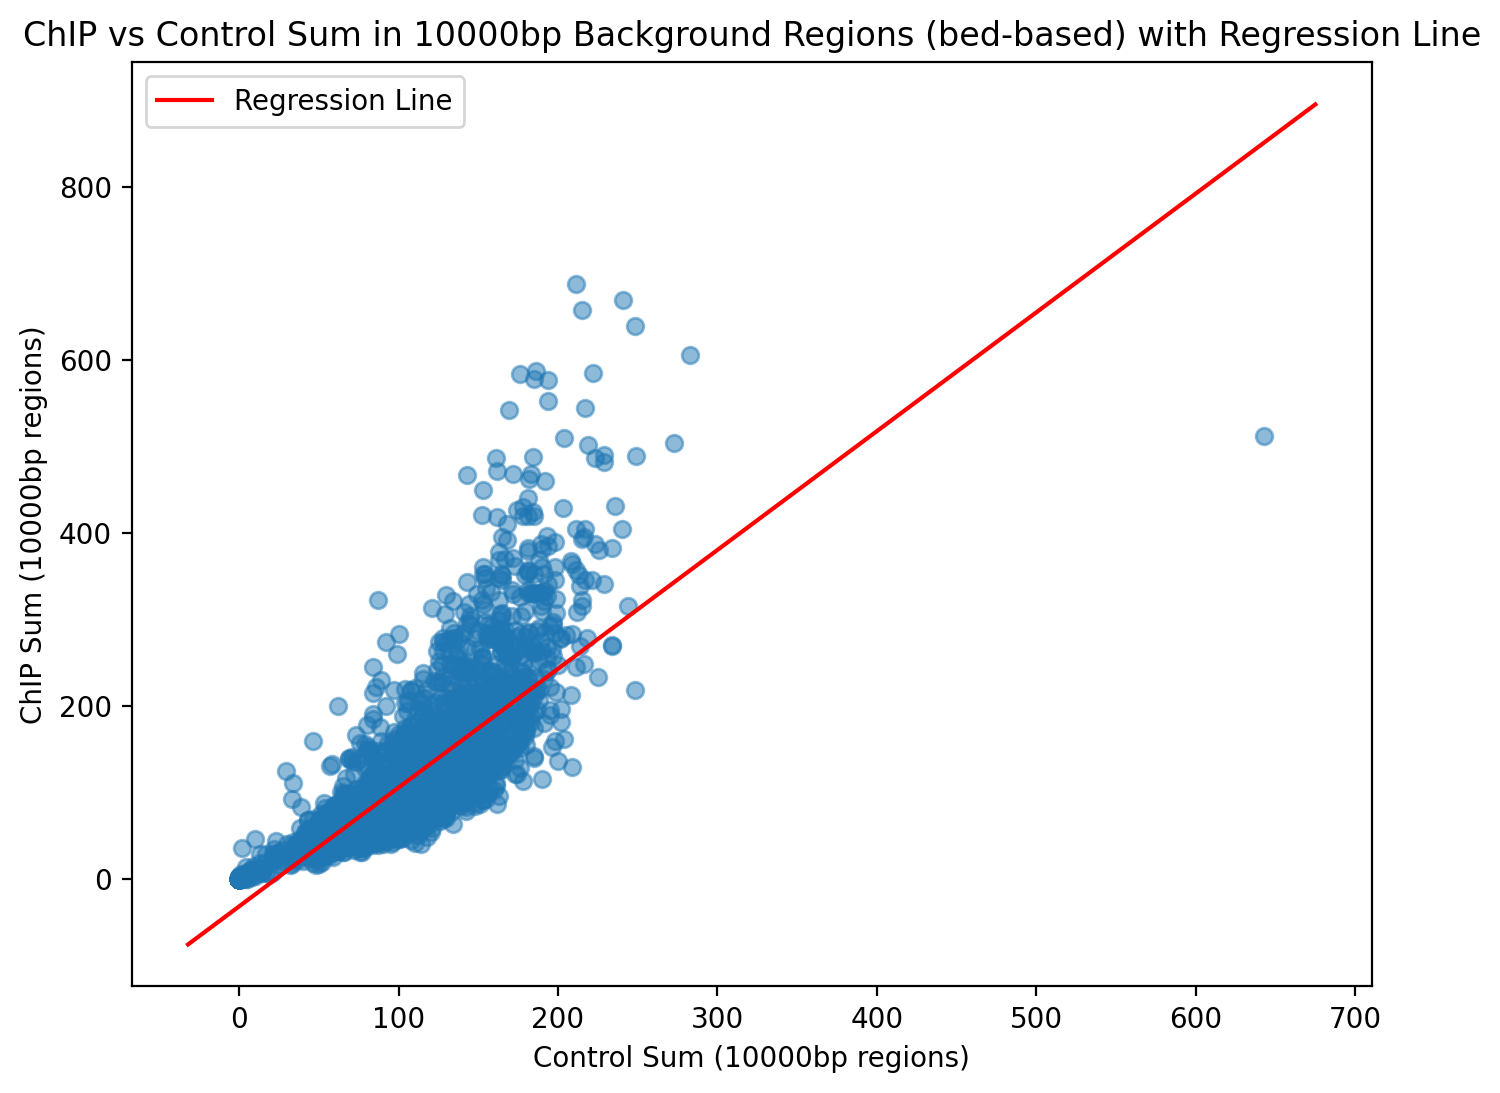

Scaling factor (slope of regression line): 1.3720351606543661
Intercept of regression line: -31.370788725227783


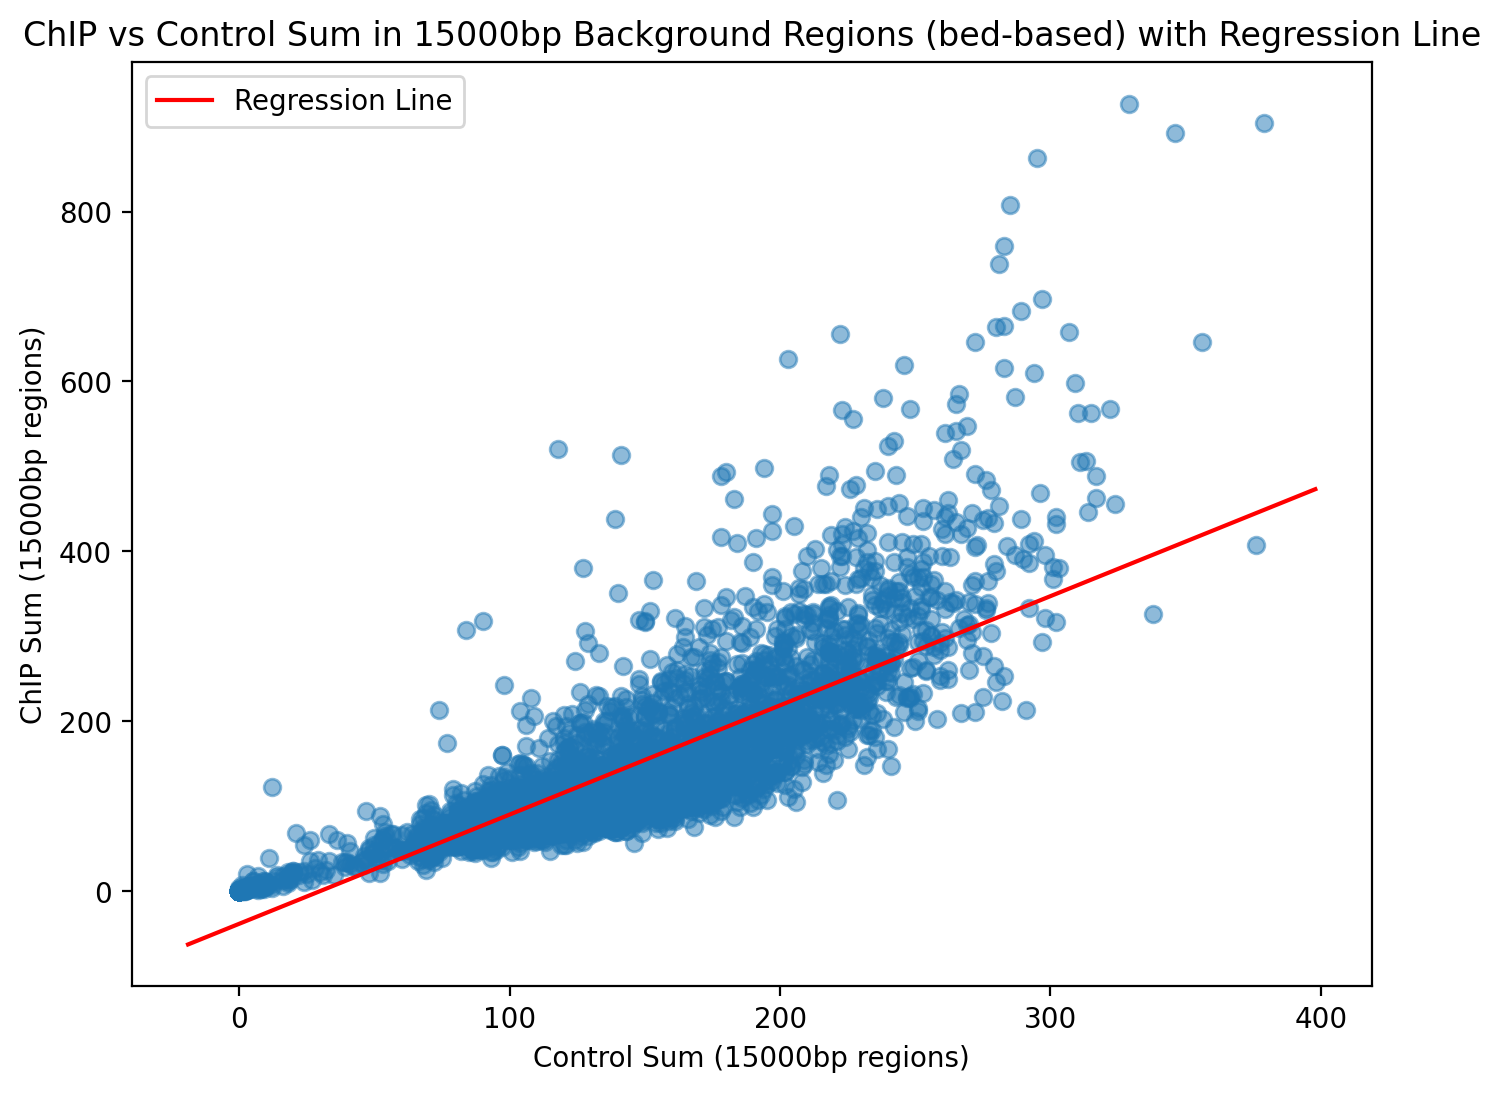

Scaling factor (slope of regression line): 1.28504911835332
Intercept of regression line: -38.13638822283278


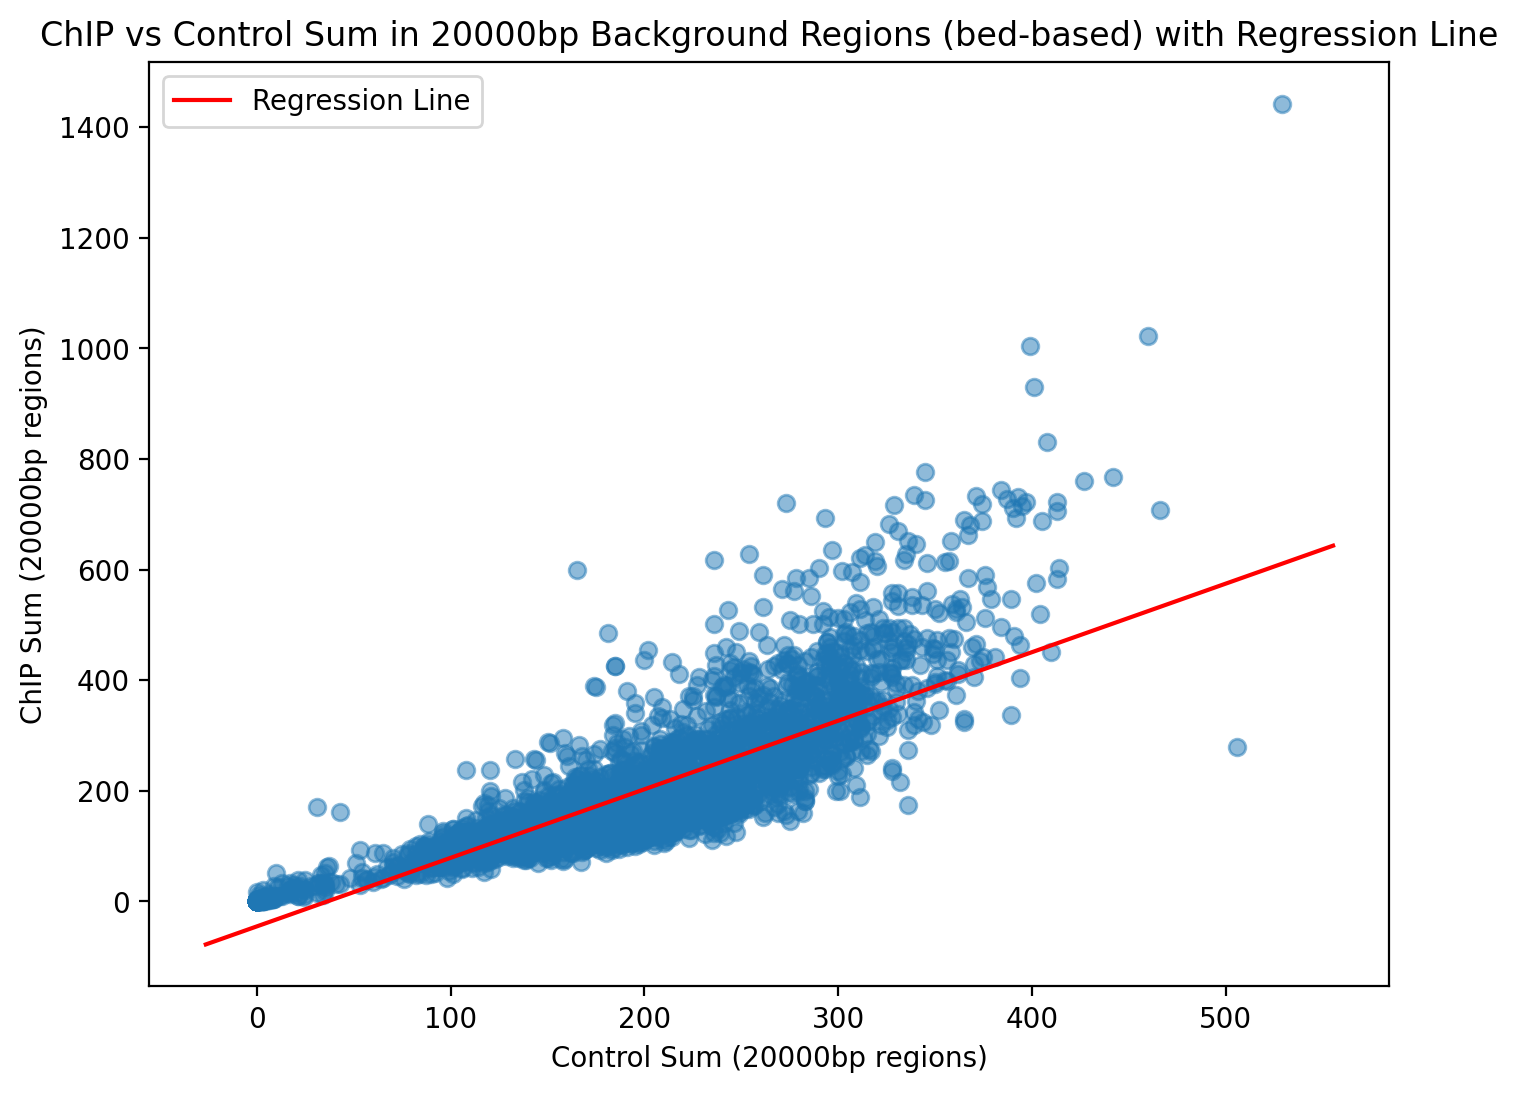

Scaling factor (slope of regression line): 1.2391879160493575
Intercept of regression line: -45.136852373781096


In [71]:
run_for_L_4(100, bed_based = True)
run_for_L_4(500, bed_based = True)
run_for_L_4(1000, bed_based = True)
run_for_L_4(5000, bed_based = True)
run_for_L_4(10000, bed_based = True)
run_for_L_4(15000, bed_based = True)
run_for_L_4(20000, bed_based = True)

In [ ]:
import matplotlib.pyplot as plt
# import statsmodels.api as sm

# # fit model using statsmodels so we can access full diagnostics
# X = sm.add_constant(sum_ctrl_)
# model = sm.OLS(sum_, X).fit()

fitted = model.fittedvalues
residuals = model.resid

plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()
Q–Q Plot

python
Copy code
sm.qqplot(residuals, line='45')
plt.title("Q–Q Plot")
plt.show()
If you want to keep using scikit-learn for fitting, you can still compute residuals the same way:

python
Copy code
pred = model.predict(sum_ctrl_.reshape(-1, 1))
residuals = sum_ - pred

Trying log for a second

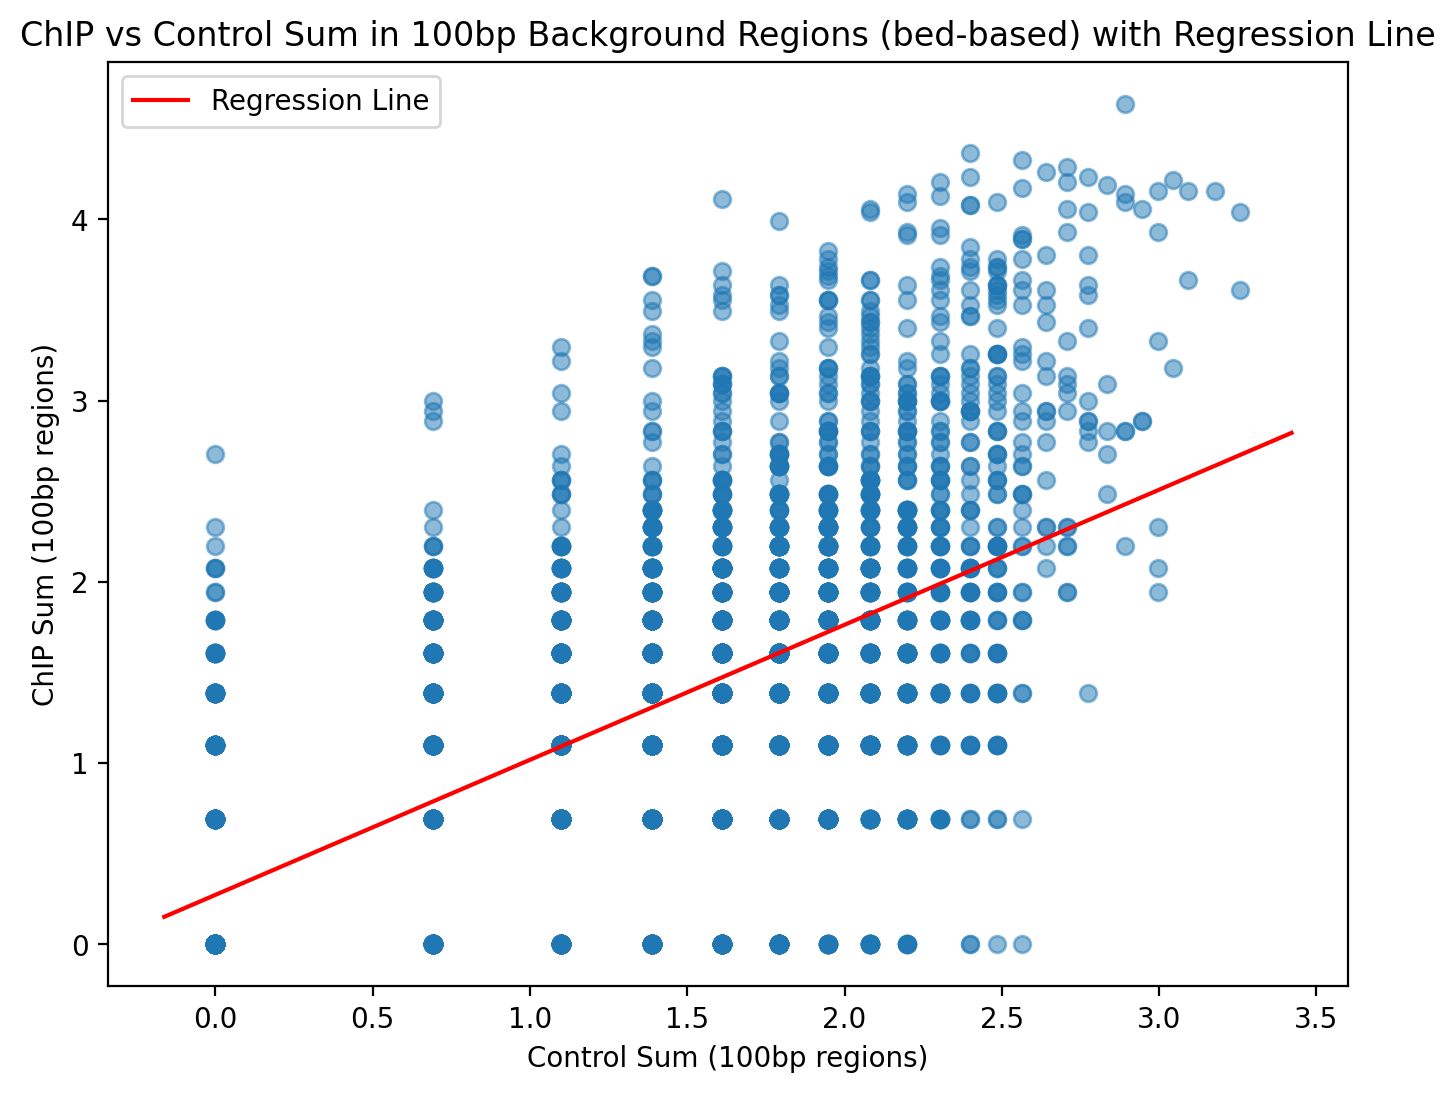

Scaling factor (slope of regression line): 0.745066301086692
Intercept of regression line: 0.2736835537594089


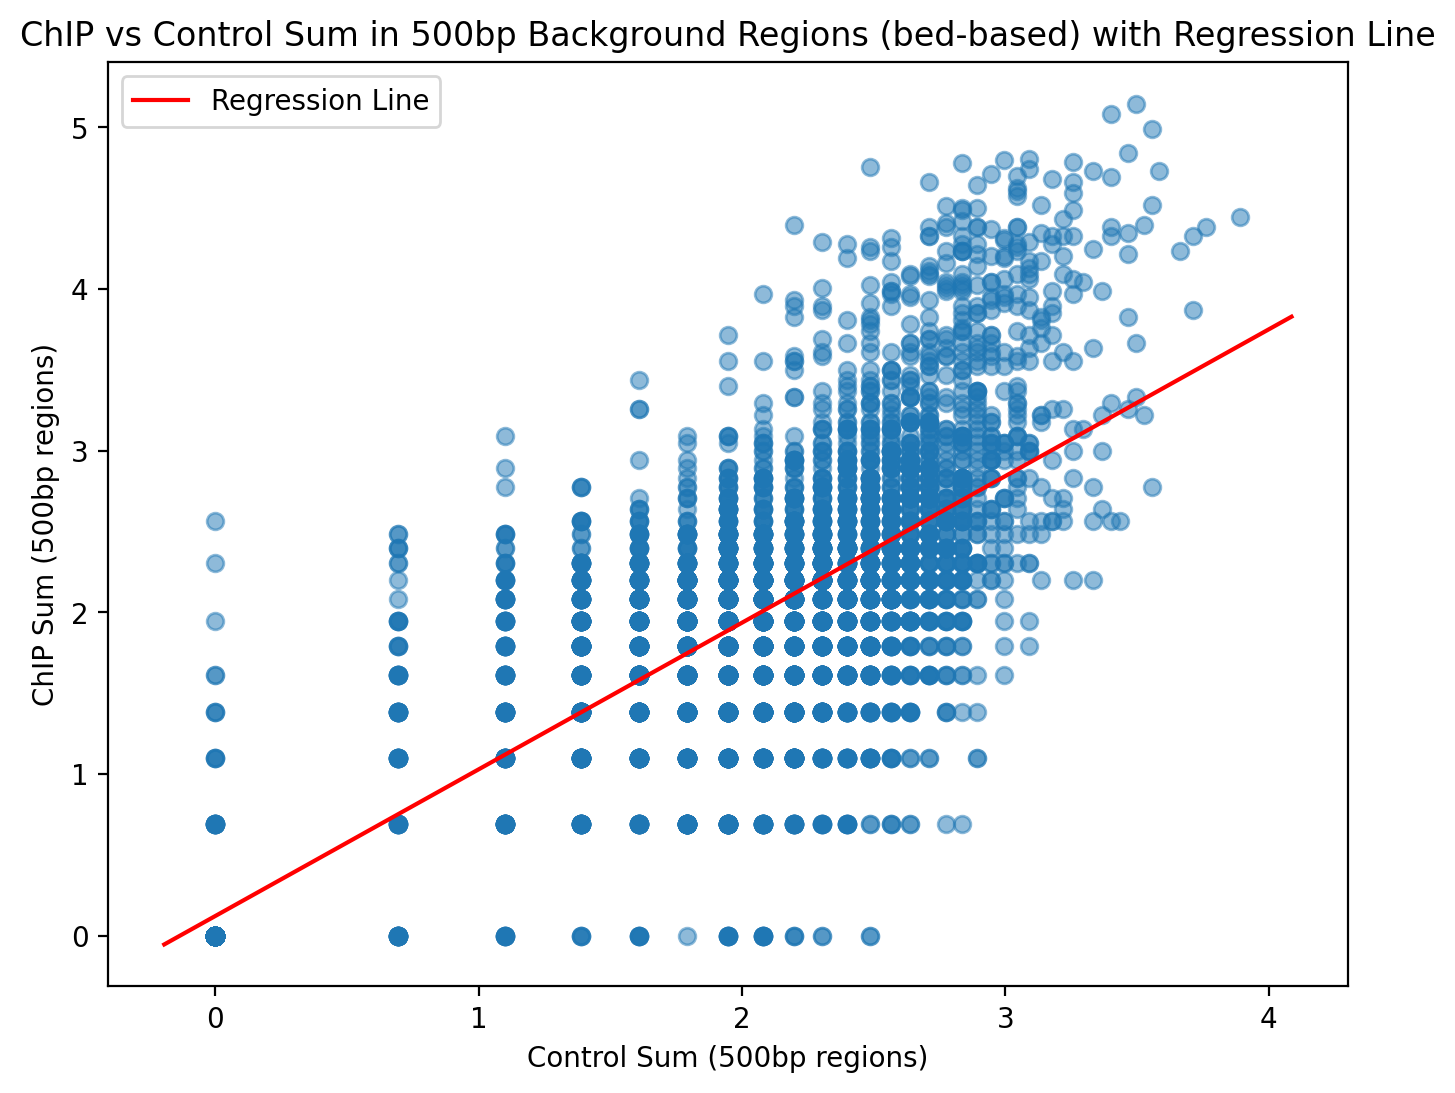

Scaling factor (slope of regression line): 0.9071079945062639
Intercept of regression line: 0.12192385896760638


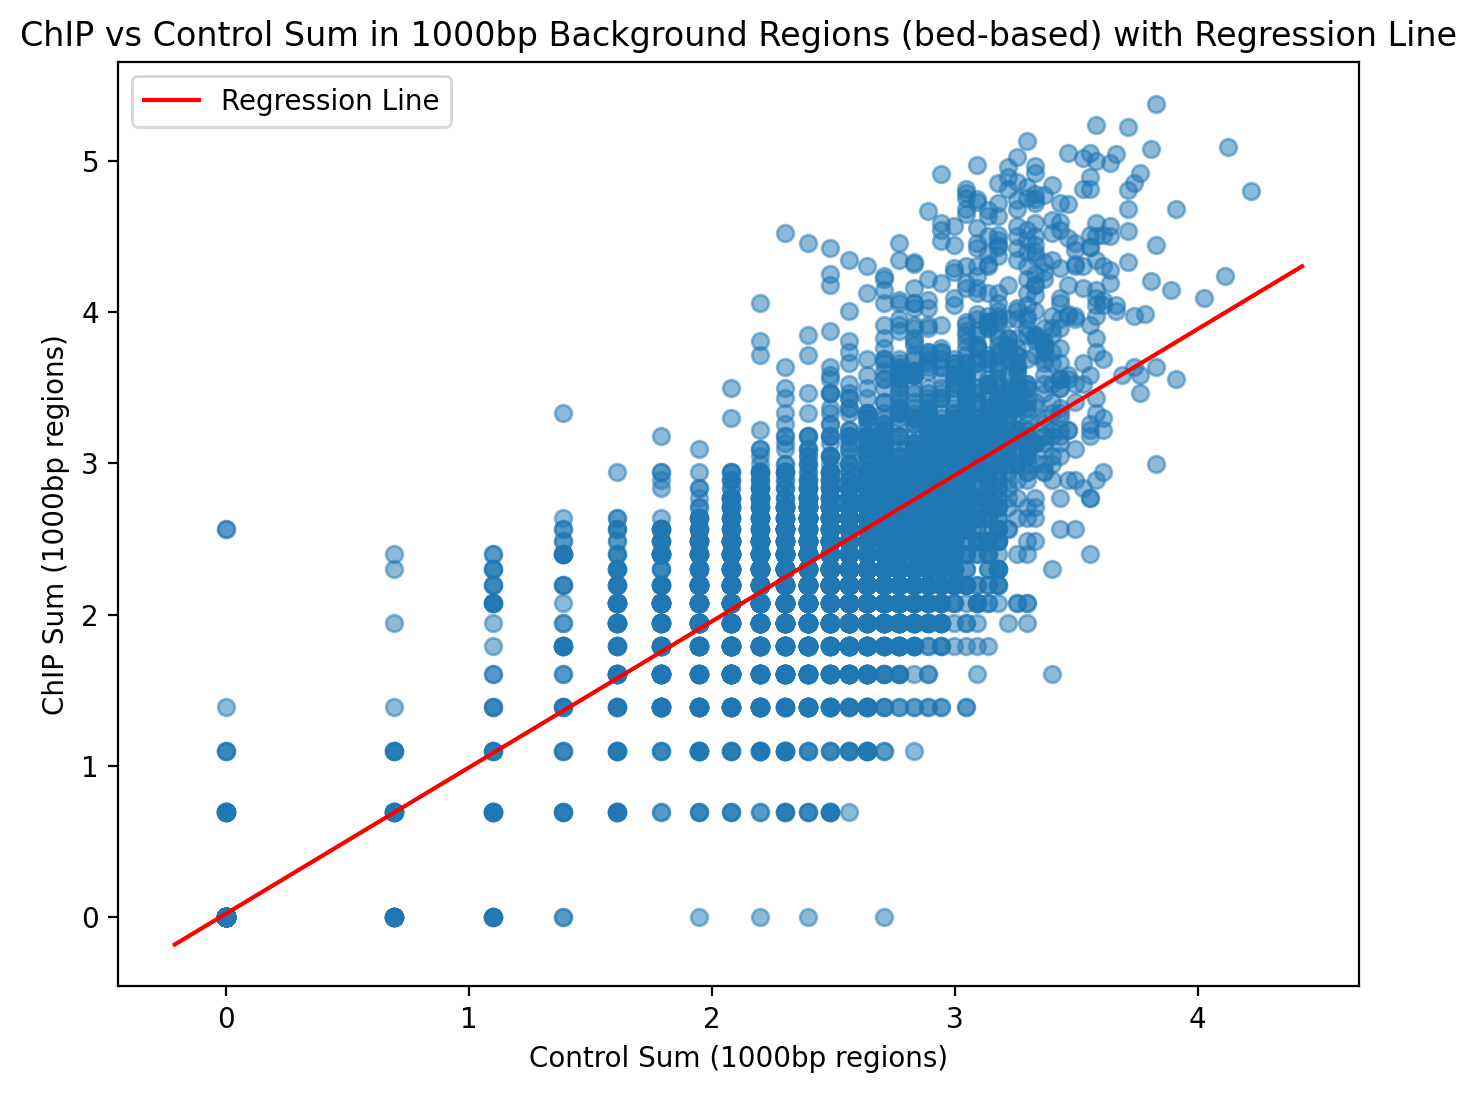

Scaling factor (slope of regression line): 0.9655094223284645
Intercept of regression line: 0.02392668627029737


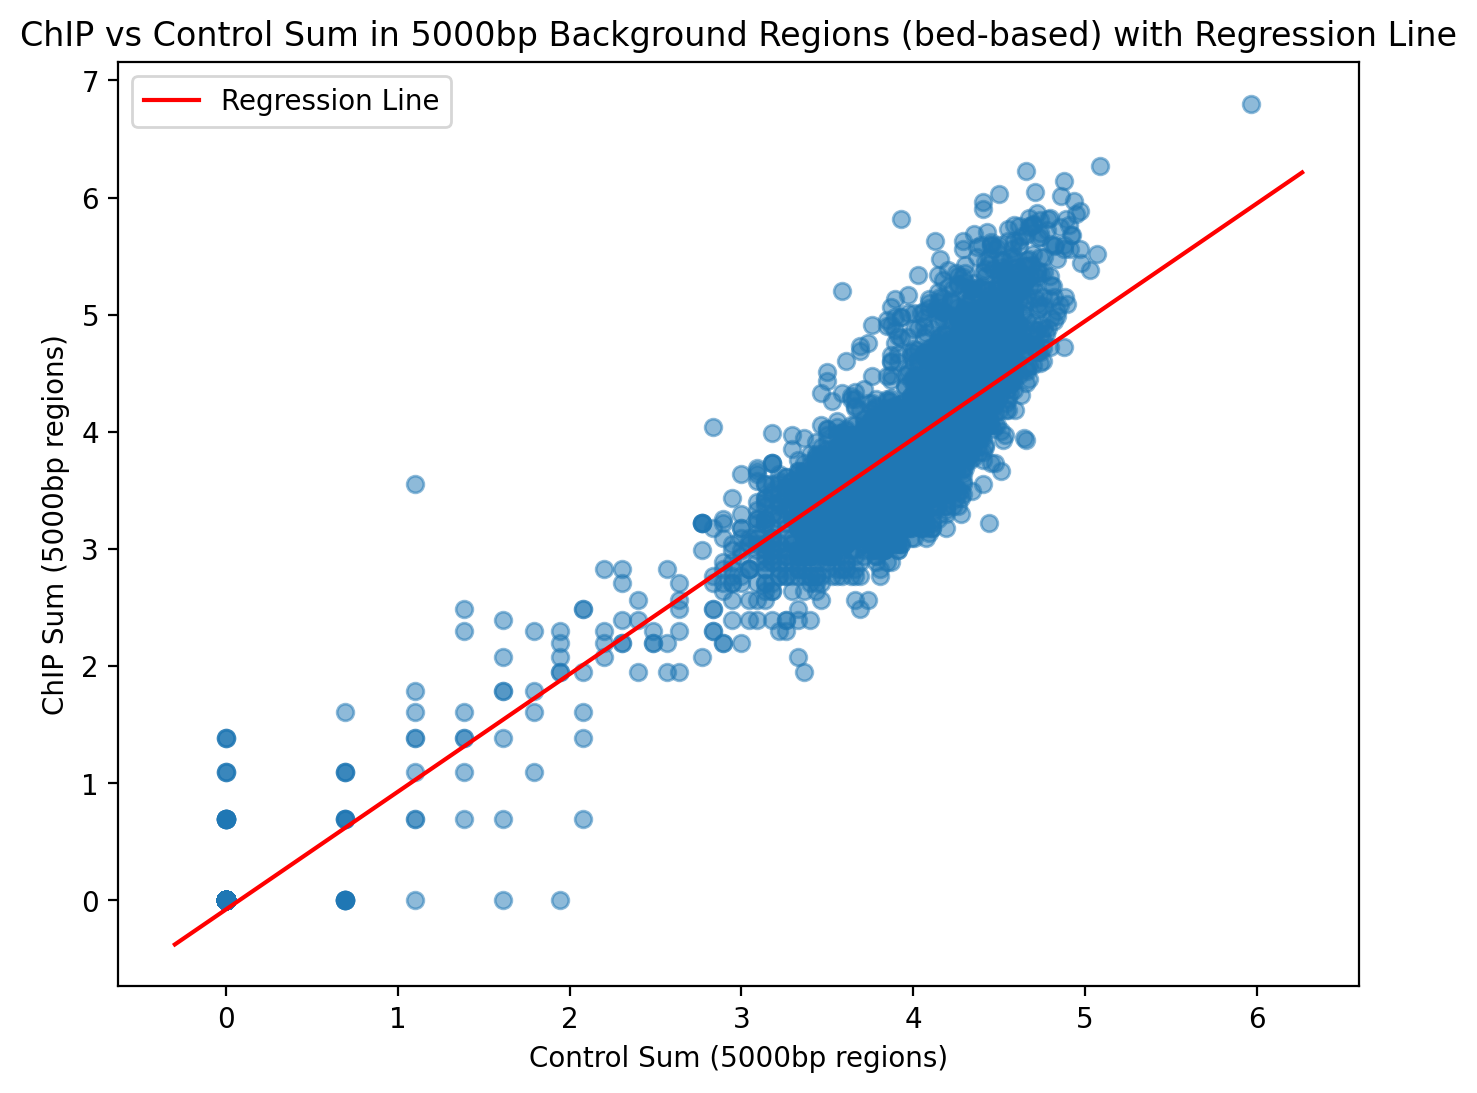

Scaling factor (slope of regression line): 1.0040676191914617
Intercept of regression line: -0.07580804228451443


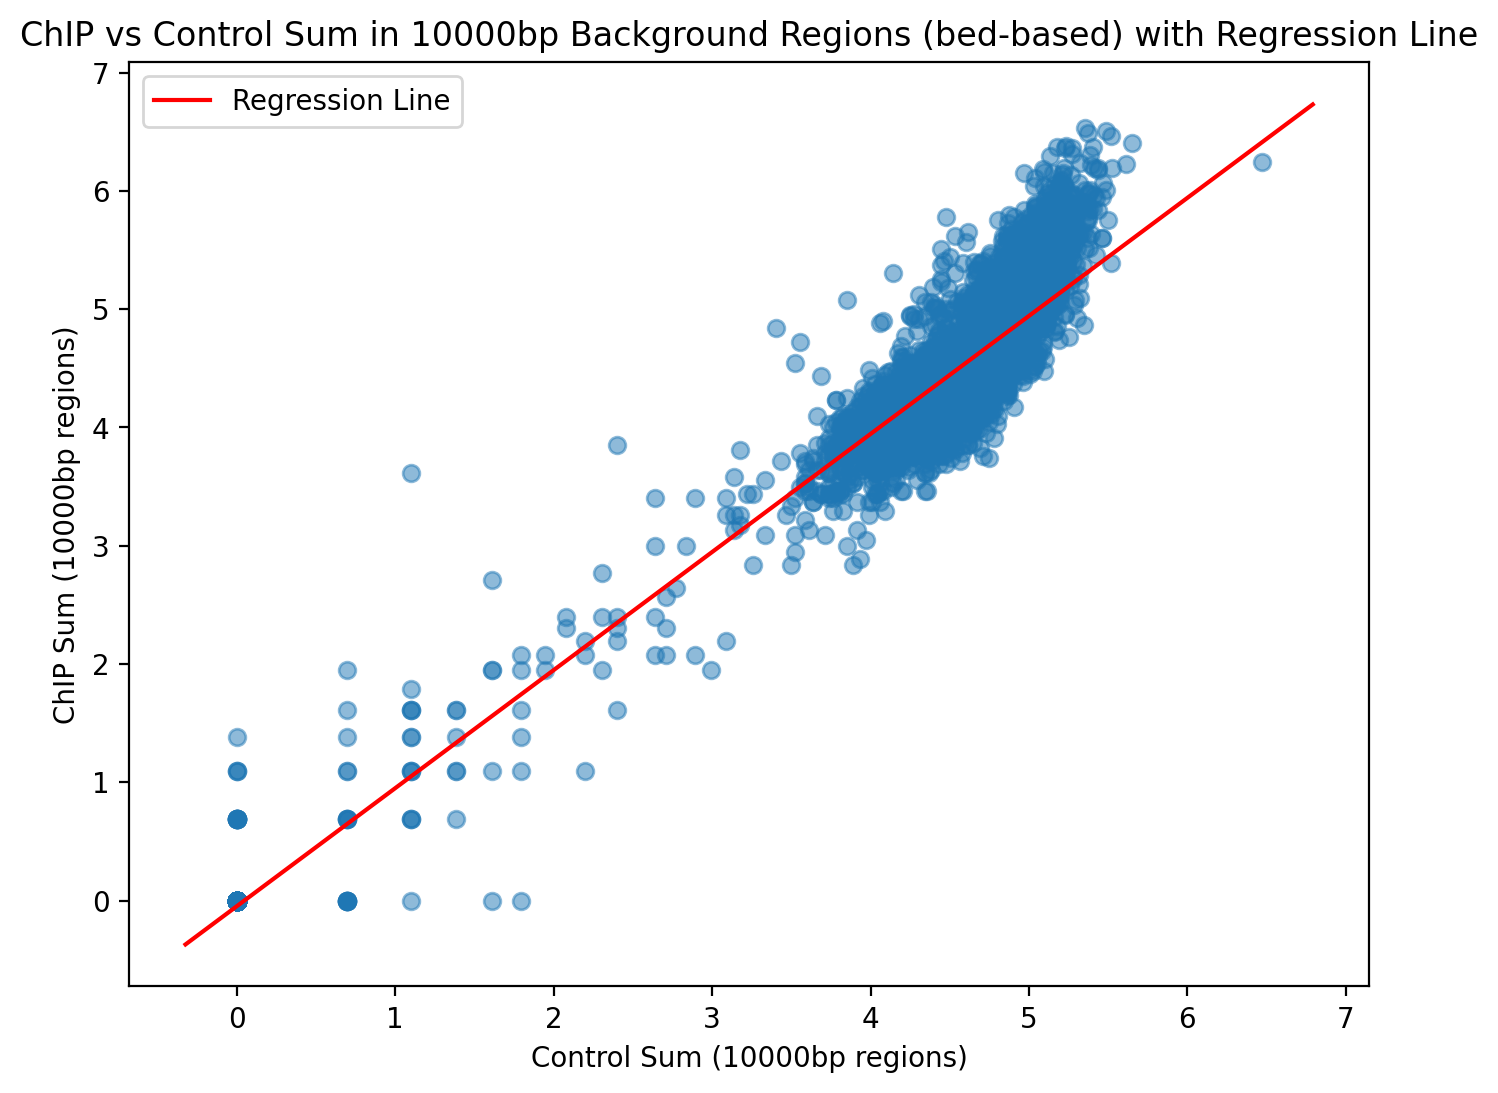

Scaling factor (slope of regression line): 0.9981695041853677
Intercept of regression line: -0.04835863850298061


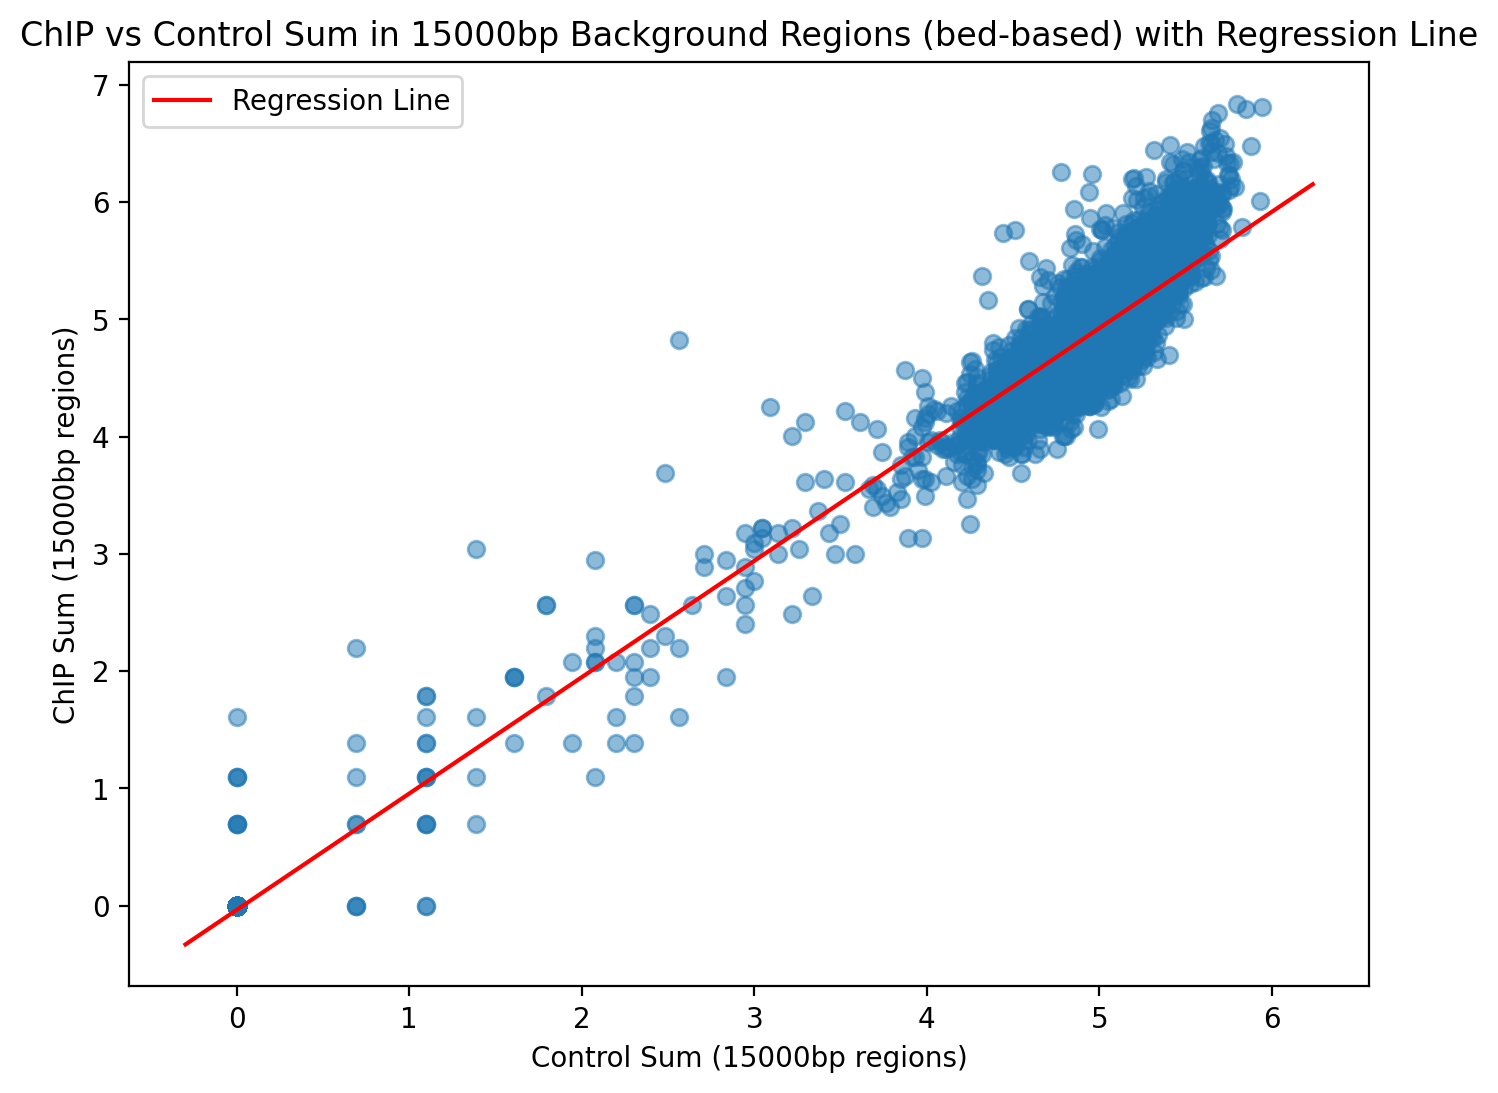

Scaling factor (slope of regression line): 0.9920011838533013
Intercept of regression line: -0.03569804422044687


In [59]:
run_for_L_4(100, bed_based = True, do_log = True)
run_for_L_4(500, bed_based = True, do_log = True)
run_for_L_4(1000, bed_based = True, do_log = True)
run_for_L_4(5000, bed_based = True, do_log = True)
run_for_L_4(10000, bed_based = True, do_log = True)
run_for_L_4(15000, bed_based = True, do_log = True)

# Checking pearson correlations

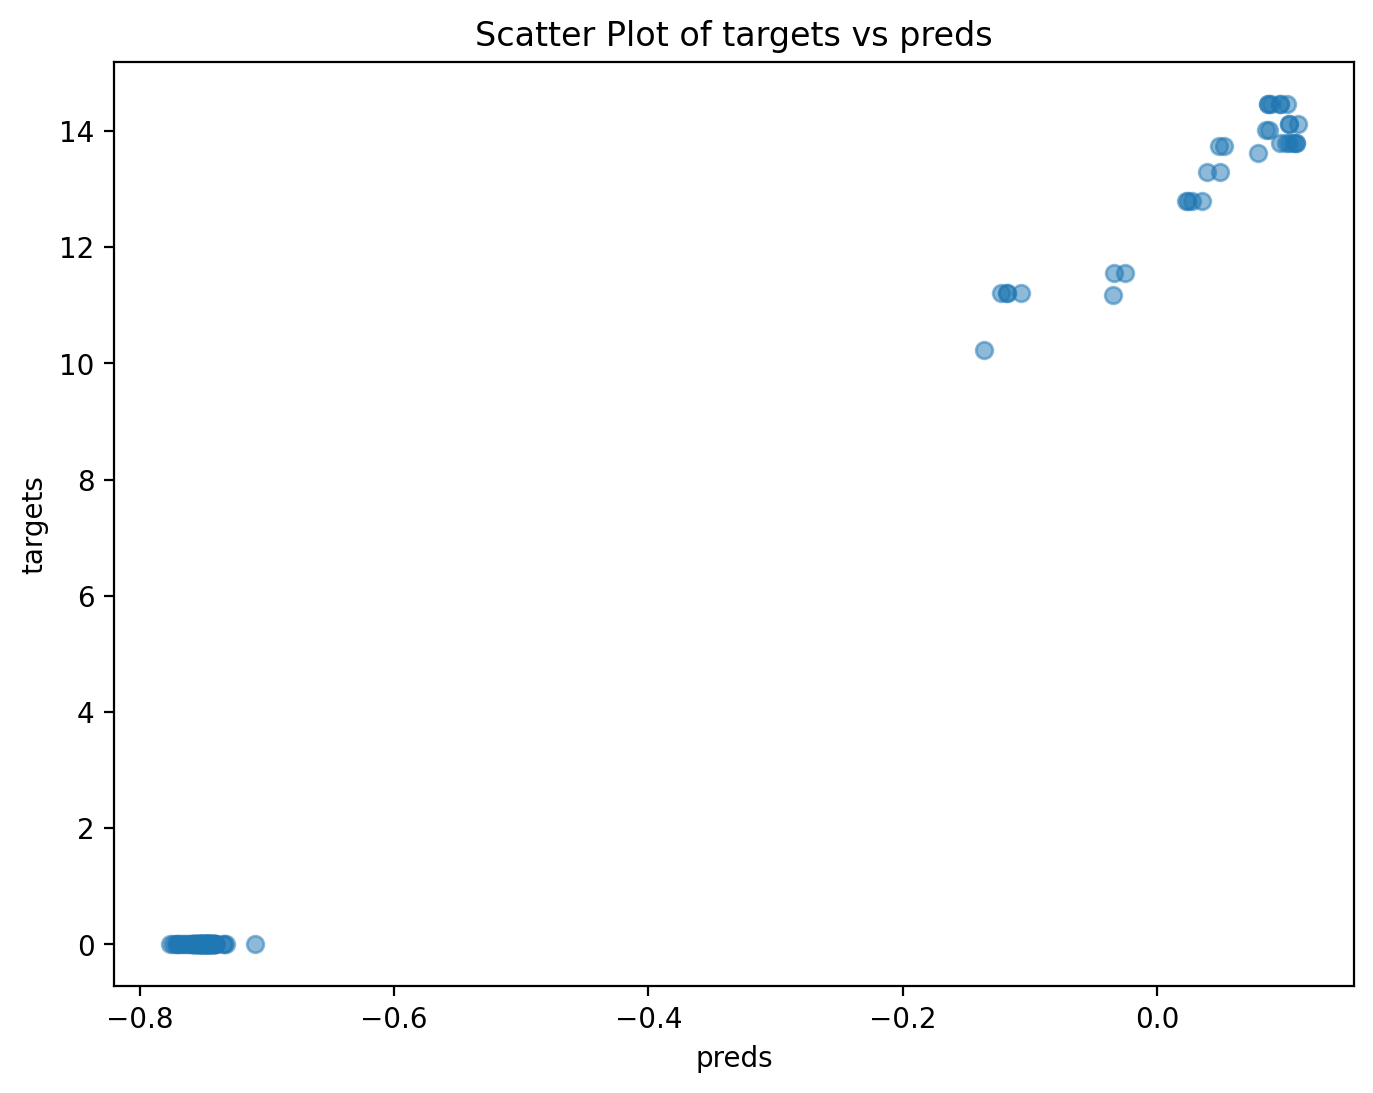

Pearson correlation: 0.99910497899927
Spearman correlation: 0.7729004953637979
mean of x: -0.54019140625
mean of y: 3.50072578125
Covariance: 2.0555638281378172
Standard deviation of x: 0.3513927481348647
Standard deviation of y: 5.8550020168688635


In [ ]:
# x = tensor([-0.7414, -0.7516, -0.7470, -0.7537, -0.7574, -0.1360, -0.7649, -0.7476,
#         -0.7512, -0.7468, -0.7477, -0.7534, -0.7456, -0.7427, -0.7590, -0.7474,
#         -0.7467,  0.0873,  0.0966,  0.0894,  0.0969,  0.0870,  0.1023,  0.0794,
#         -0.7423, -0.7486,  0.0394,  0.0499, -0.7442, -0.7405,  0.1039,  0.1105,
#          0.1040, -0.7339, -0.7346, -0.7509, -0.0339, -0.7497, -0.7445, -0.7480,
#         -0.7461,  0.0856,  0.0882, -0.7453, -0.0343, -0.7530, -0.7564, -0.7476,
#         -0.7417, -0.7546, -0.7565,  0.1070,  0.1093,  0.1095,  0.1035,  0.0966,
#          0.1016, -0.7541, -0.7501, -0.7410, -0.7527,  0.0224,  0.0272,  0.0243,
#          0.0354, -0.0254, -0.7524, -0.7514, -0.7546, -0.7489, -0.7509, -0.7697,
#         -0.7489, -0.7705, -0.7402, -0.1177, -0.1070, -0.7597, -0.7453, -0.1230,
#         -0.1177, -0.7452, -0.7439, -0.7555, -0.7486, -0.7527, -0.7428, -0.7429,
#         -0.7502, -0.7419, -0.7565, -0.7408, -0.7433, -0.7463, -0.7758, -0.7710,
#         -0.7740, -0.7461, -0.7586, -0.7520, -0.7461, -0.7427, -0.7500, -0.7409,
#         -0.7323, -0.7486, -0.7685, -0.7655, -0.7523, -0.7455, -0.7093, -0.7579,
#         -0.7482, -0.7542, -0.7445, -0.7537, -0.7626, -0.7560,  0.0525,  0.0486,
#         -0.7505, -0.7481, -0.7617, -0.7505, -0.7513, -0.7583, -0.7443, -0.7433],
#        device='cuda:0')
# all_targets
# tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 10.2380,  0.0000,  0.0000,
#          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#          0.0000, 14.4555, 14.4555, 14.4555, 14.4555, 14.4555, 14.4555, 13.6248,
#          0.0000,  0.0000, 13.2942, 13.2942,  0.0000,  0.0000, 14.1254, 14.1254,
#         14.1254,  0.0000,  0.0000,  0.0000, 11.5539,  0.0000,  0.0000,  0.0000,
#          0.0000, 14.0129, 14.0129,  0.0000, 11.1746,  0.0000,  0.0000,  0.0000,
#          0.0000,  0.0000,  0.0000, 13.7943, 13.7943, 13.7943, 13.7943, 13.7943,
#         13.7943,  0.0000,  0.0000,  0.0000,  0.0000, 12.7861, 12.7861, 12.7861,
#         12.7861, 11.5516,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#          0.0000,  0.0000,  0.0000, 11.2071, 11.2071,  0.0000,  0.0000, 11.2071,
#         11.2071,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
#          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 13.7440, 13.7440,
#          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
#        device='cuda:0')

x = np.array([-0.7414, -0.7516, -0.7470, -0.7537, -0.7574, -0.1360, -0.7649, -0.7476,
        -0.7512, -0.7468, -0.7477, -0.7534, -0.7456, -0.7427, -0.7590, -0.7474,
        -0.7467,  0.0873,  0.0966,  0.0894,  0.0969,  0.0870,  0.1023,  0.0794,
        -0.7423, -0.7486,  0.0394,  0.0499, -0.7442, -0.7405,  0.1039,  0.1105,
        0.1040, -0.7339, -0.7346, -0.7509, -0.0339, -0.7497, -0.7445, -0.7480,
        -0.7461,  0.0856,  0.0882, -0.7453, -0.0343, -0.7530, -0.7564, -0.7476,
        -0.7417, -0.7546, -0.7565,  0.1070,  0.1093,  0.1095,  0.1035,  0.0966,
        0.1016, -0.7541, -0.7501, -0.7410, -0.7527,  0.0224,  0.0272,  0.0243,
        0.0354, -0.0254, -0.7524, -0.7514, -0.7546, -0.7489, -0.7509, -0.7697,
        -0.7489, -0.7705, -0.7402, -0.1177, -0.1070, -0.7597, -0.7453, -0.1230,
        -0.1177, -0.7452, -0.7439, -0.7555, -0.7486, -0.7527, -0.7428, -0.7429,
        -0.7502, -0.7419, -0.7565, -0.7408, -0.7433, -0.7463, -0.7758, -0.7710,
        -0.7740, -0.7461, -0.7586, -0.7520, -0.7461, -0.7427, -0.7500, -0.7409,
        -0.7323, -0.7486, -0.7685, -0.7655, -0.7523, -0.7455, -0.7093, -0.7579,
        -0.7482, -0.7542, -0.7445, -0.7537, -0.7626, -0.7560,  0.0525,  0.0486,
        -0.7505, -0.7481, -0.7617, -0.7505, -0.7513, -0.7583, -0.7443, -0.7433])

y = np.array([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 10.2380,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, 14.4555, 14.4555, 14.4555, 14.4555, 14.4555, 14.4555, 13.6248,
         0.0000,  0.0000, 13.2942, 13.2942,  0.0000,  0.0000, 14.1254, 14.1254,
        14.1254,  0.0000,  0.0000,  0.0000, 11.5539,  0.0000,  0.0000,  0.0000,
         0.0000, 14.0129, 14.0129,  0.0000, 11.1746,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, 13.7943, 13.7943, 13.7943, 13.7943, 13.7943,
        13.7943,  0.0000,  0.0000,  0.0000,  0.0000, 12.7861, 12.7861, 12.7861,
        12.7861, 11.5516,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, 11.2071, 11.2071,  0.0000,  0.0000, 11.2071,
        11.2071,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 13.7440, 13.7440,
        0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

# filter out 0's from y and the correspoinding x entires
mask = y != 0
x = x[mask]
y = y[mask]

# plot the above arrays
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel("preds")
plt.ylabel("targets")
plt.title("Scatter Plot of targets vs preds")
plt.show()

import scipy.stats

# pearsonr
print("Pearson correlation:", np.corrcoef(x, y)[0, 1])
# spearmanr
print("Spearman correlation:", scipy.stats.spearmanr(x, y).correlation)

# x - E[x]
x_centered = x - np.mean(x)
# y - E[y]
y_centered = y - np.mean(y)
# covariance
cov_xy = np.mean(x_centered * y_centered)
# standard deviations
std_x = np.std(x)
std_y = np.std(y)
print("mean of x:", np.mean(x))
print("mean of y:", np.mean(y))
print("Covariance:", cov_xy)
print("Standard deviation of x:", std_x)
print("Standard deviation of y:", std_y)